In [77]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations  # For creating combinations of elements
import gc  # Garbage collection for memory management
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import tqdm
from sklearn.linear_model import ElasticNet
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py
/kaggle/input/df-target-train/target_train.pkl
/kaggle/input/df-target-train/df_train54.pkl


### Load Data

In [ ]:
%%time
DATA_DIR = '/kaggle/input/'
df = pd.read_csv(os.path.join(DATA_DIR, 'optiver-trading-at-the-close', 'train.csv')).drop(['time_id','row_id'],axis=1)
df_train = df.dropna(subset=['target'])
target_train = df_train['target']
df_train.drop('target',axis=1, inplace=True)
df_train.head()

### Inspect Columns

In [ ]:
def inspect_columns(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
#         'null_num': df.isnull().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
#         '1st_row': df.iloc[0],
#         'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)
# seconds_in_bucket is from 0s to 540s inclusive, therefore 55 snapshots
# target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.

In [ ]:
temp = inspect_columns(df)
print(temp.to_latex(float_format="{:.1f}".format))
del temp

# Exploratory Analysis

In [ ]:
sns.set_theme()

### Visualize feature distribution under different target conditions(positive target & negative target)

In [ ]:
df['target_sign'] = 'Negative'
df['target_sign'][df['target'] >= 0] = 'Positive'

In [ ]:
cols = ['seconds_in_bucket', 'bid_price', 'ask_price', 'far_price', 'near_price','reference_price', 'wap',
        'ask_size','bid_size','imbalance_size', 'matched_size', 'target']
fig, axes = plt.subplots(4, 3, figsize = (17, 12))
for i, col in enumerate(cols):
    ax = axes[i // 3, i % 3 ]
    hist_kwargs = dict(ax=ax, alpha=0.8, bins=90, stat='frequency',)
    sns.histplot(data = df, x = col, hue = 'target_sign', **hist_kwargs)
    ax.set_title(f"{col}")
    ax.set(yscale='log')
plt.tight_layout()
plt.show()

### Plot data for a single day along the seconds

In [ ]:
cols = ['bid_price', 'ask_price', 'far_price', 'near_price','reference_price', 'wap',
        'ask_size','bid_size','imbalance_size', 'matched_size', 'imbalance_buy_sell_flag', 'target']
fig, axes = plt.subplots(4, 3, figsize = (17, 12))
_ = df.query("stock_id == 10 & date_id == 2")
for i, col in enumerate(cols):
    ax = axes[i // 3, i % 3 ]
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

### Scatter Plot

In [ ]:
cols =  ['seconds_in_bucket', 'bid_price', 'ask_price', 'far_price', 'near_price','reference_price', 'wap',
        'ask_size','bid_size','imbalance_size', 'matched_size', 'imbalance_buy_sell_flag']
fig, axes = plt.subplots(4, 3, figsize = (17, 12))
# _ = df.query("stock_id == 10 & date_id == 2")
for i, col in enumerate(cols):
    ax = axes[i // 3, i % 3 ]
    sns.scatterplot(data = df, x = col, y = 'target', ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

### Plot Correlation Map 

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
cols =  ['stock_id', 'date_id', 'seconds_in_bucket', 'bid_price', 'ask_price', 'far_price', 'near_price','reference_price', 'wap',
        'ask_size','bid_size','imbalance_size', 'matched_size', 'imbalance_buy_sell_flag', 'target']
corr = df[cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".2f")

In [ ]:
del df

# feature engineering

### Ancillary Function to reduce RAM usage

In [57]:
# Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, verbose=0):
    """Iterate through all numeric columns of a dataframe and modify the data type to reduce memory usage."""
    
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtypes

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # Provide memory optimization information if 'verbose' is True
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

In [ ]:
df_train = reduce_mem_usage(df_train, verbose=0)
df_train.tail()

### Single Stock Features

In [ ]:
%%time

def calc_feature_single_stock(df):
    # Feature of each stock at different time point
    # date_id
    df["date_id_week"] = df["date_id"] % 5  # Day of the week
    df["date_id_seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    df["date_id_minute"] = df["seconds_in_bucket"] // 60  # Minutes
    
    # ask bid 
    df['spread'] = df['ask_price'] - df['bid_price']
    df['spread_ratio'] = df['ask_price'] / df['bid_price'] - 1
    df['mid_price'] = (df['bid_price'] + df['ask_price'])/2
    
    # ask_size bid_size
    df["total_volume"] = df['ask_size'] + df['bid_size']
    df["volume_imbalance_v1"] = (df['bid_size'] - df['ask_size']) / df["total_volume"]
    df["volume_imbalance_v2"] = df['ask_size'] / df['bid_size']
    df["volume_imbalance_v3"] = df['ask_size'] - df['bid_size']
    
    # near_price far_price
    df['near_far_ratio'] = df['near_price'] / df['far_price']
    df['near_far_imbalance'] = (df['far_price'] - df['near_price']) / (df['far_price'] + df['near_price'])
    df['near_far_mid'] = (df['near_price'] + df['far_price'])/2
    df['near_far_spread'] = df['far_price'] - df['far_price']
    
    # imbalance_size matched_size
    df['auction_volume'] = df['imbalance_size'] + df['matched_size']
    df["imbalance_ratio_v1"] = (df['matched_size'] - df['imbalance_size']) / df['auction_volume']
    df["imbalance_ratio_v2"] = df['imbalance_size'] / df['auction_volume']

    # cross term 
    df["imbalance_continuous_ratio"] = df['imbalance_size'] / df["total_volume"]
    df['imbalance_support_v1'] = df['spread'] * df['imbalance_size']
    df['imbalance_support_v2'] = df['spread'] * df["volume_imbalance_v1"]
    df['imbalance_support_v3'] = df['spread'] * df["imbalance_ratio_v1"]
    df['depth_pressure'] = df["volume_imbalance_v1"] * df['near_far_imbalance']
    df['market_activity'] = df['bid_size'] * df['bid_price'] + df['ask_size'] * df['ask_price']
    df["price_volume_imbalance_v1"] = (df['bid_size'] * df['bid_price'] - df['ask_size'] * df['ask_price']) / df['market_activity']
    df["price_volume_imbalance_v2"] = (df['bid_size'] * df['bid_price'] - df['ask_size'] * df['ask_price']) / df['auction_volume']
    df['ask_wap_diff'] = df['ask_price'] - df['wap']
    df['bid_wap_diff'] = df['wap'] - df['bid_size']
    df['price_according_to_flag'] = np.where(df['imbalance_buy_sell_flag'].map({1:True,-1:False}),df['bid_price'],df['ask_price'])
    df['size_according_to_flag'] = np.where(df['imbalance_buy_sell_flag'].map({1:True,-1:False}),df['bid_size'],df['ask_size'])
    df['imbalance_strength_v1'] = df['imbalance_size'] * df['price_according_to_flag']
    df['imbalance_strength_v2'] = df['size_according_to_flag'] * df['price_according_to_flag']
    df['imbalance_auction_continuous_v1'] = df['near_far_spread'] * df['imbalance_size']
    df['imbalance_auction_continuous_v2'] = df['near_far_spread'] * df['matched_size']
    df['sign_imbalance_size'] = df['imbalance_buy_sell_flag'] * df['imbalance_size']
    
    # 14850 is sum of seconds_in_bucket for a single day
    df["imbalance_ratio_along_seconds"] = df["imbalance_ratio_v2"] * df["seconds_in_bucket"] / 14850
    df["near_far_spread_along_seconds"] = df["near_far_spread"] * df["seconds_in_bucket"] / 14850
    df["volume_imbalance_along_seconds"] = df["volume_imbalance_v3"] * df["seconds_in_bucket"] / 14850
    df['imbalance_strength_along_seconds'] = df["volume_imbalance_v3"] * df["seconds_in_bucket"] / 14850
    df['spread_along_seconds'] = df['spread'] * df["seconds_in_bucket"] / 14850
    
    # statistical features at different time point
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    for func in ["mean", "std", "skew", "kurt"]:
            df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
            df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
            
    # Accumulative features
    df['imbalance_buy_sell_flag_cumsum'] =  df.groupby(['stock_id','date_id'])['imbalance_buy_sell_flag'].cumsum()
    df['size_according_to_flag_cumsum'] =  df.groupby(['stock_id','date_id'])['size_according_to_flag'].cumsum()
    
    df = reduce_mem_usage(df, verbose=0)
    return df

df_train = calc_feature_single_stock(df_train)
df_train.tail()

### Cross Sectional Features

In [ ]:
%%time
def calc_cross_sectional_features(df,attributes):
    # Cross Sectional Mean
    temp = df.groupby(['date_id','seconds_in_bucket'])[attributes].mean().add_suffix('_cross_sectional_mean').reset_index()
    df = df.merge(temp,how='left',on=['date_id','seconds_in_bucket'])
    
    # Cross Sectional std
    temp = df.groupby(['date_id','seconds_in_bucket'])[attributes].std().add_suffix('_cross_sectional_std').reset_index()
    df = df.merge(temp,how='left',on=['date_id','seconds_in_bucket'])
    
    # Cross Sectional skew
    temp = df.groupby(['date_id','seconds_in_bucket'])[attributes].skew().add_suffix('_cross_sectional_skew').reset_index()
    df = df.merge(temp,how='left',on=['date_id','seconds_in_bucket'])
    
    # Cross Sectional rank
    temp = df.groupby(['date_id','seconds_in_bucket'])[attributes].rank(pct=True).add_suffix('_cross_sectional_rank')
    df = pd.concat([df,temp],axis=1)
    
    df = reduce_mem_usage(df, verbose=0)
    return df

attributes = ['imbalance_support_v1','imbalance_support_v2','imbalance_support_v3',
              'volume_imbalance_v1','volume_imbalance_v2','near_far_ratio',
             'near_far_imbalance','imbalance_ratio_v1','imbalance_ratio_v2',
             'imbalance_continuous_ratio','depth_pressure','market_activity',
             'price_volume_imbalance_v1','price_volume_imbalance_v2',
             "reference_price", "far_price", "near_price",
             "matched_size", "bid_size", "ask_size", "imbalance_size"]
df_train = calc_cross_sectional_features(df_train,attributes)
df_train.tail()

In [ ]:
gc.collect()

In [ ]:
# ts -> time series
def calc_ts_diff(df,inidicator_list):
    df_diff1 = df.groupby(['stock_id'])[inidicator_list].diff(1)
    df_diff1 = df_diff1.add_suffix('_diff1')
    df_diff2 = df.groupby(['stock_id'])[inidicator_list].diff(2)
    df_diff2 = df_diff2.add_suffix('_diff2')
    df_diff = pd.concat([df_diff1,df_diff2],axis=1)
    new_columns = df_diff.columns.difference(df.columns)
    return pd.concat([df, df_diff[new_columns]], axis=1)

def calc_ts_momentum(df,inidicator_list):
    df_momentum = df.groupby(['stock_id'])[inidicator_list].pct_change(fill_method=None)
    df_momentum = df_momentum.add_suffix('_momentum')
    new_columns = df_momentum.columns.difference(df.columns)
    return pd.concat([df, df_momentum[new_columns]], axis=1)

def calc_ts_statistical_features(df, windows, ts_feature_dict):
    temp = []
    for window in windows:
        temp.append(df.groupby(['stock_id']).rolling(window).agg(ts_feature_dict).reset_index(level=0,drop=True).sort_index())
        temp[-1].columns = ['_'.join(col) + f'_{window}' for col in temp[-1].columns]
    temp = pd.concat(temp,axis=1)
    new_columns = temp.columns.difference(df.columns)
    return pd.concat([df, temp[new_columns]], axis=1)

from numba import njit, prange

@njit(fastmath=True)
def trend_ratio(series):
    return  np.sum(series) / (np.sum(np.abs(series))+1e-6)

@njit(fastmath=True)
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

@njit(fastmath=True)
def up_var(series):
    temp = series[series>0]
    return np.sqrt(np.sum(temp**2))

@njit(fastmath=True)
def down_var(series):
    temp = series[series<0]
    return np.sqrt(np.sum(temp**2))

@njit(fastmath=True)
def calc_autocorr(series):
    return np.corrcoef(series[:-1], series[1:])[0, 1]

def calc_other_feature(df, windows, ts_feature_dict):
    temp = []
    for k,v in ts_feature_dict.items():
        for fn in v:
            for window in windows:
                temp.append(df.groupby(['stock_id'])[k].rolling(window).apply(fn, engine='numba', raw=True).reset_index(level=0,drop=True).sort_index())
                temp[-1].name = f'{k}_{fn.__name__}_{window}'
    temp = pd.concat(temp,axis=1)
    new_columns = temp.columns.difference(df.columns)
    return pd.concat([df, temp[new_columns]], axis=1)

@njit(parallel=True,fastmath=True)
def compute_corr(df_values, comb_indices, window):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    corr = np.empty((num_rows, num_combinations))
    corr[:window,:] = np.nan
    # Loop through all combinations
    for i in prange(num_combinations):
        a, b = comb_indices[i]
        # Loop through rows of the DataFrame
        for j in range(window,num_rows):
            x = df_values[j-window:j,a]
            y = df_values[j-window:j,b]
            x_mean = x.mean()
            y_mean = y.mean()
            var_x = ((x - x_mean)**2).mean()
            var_y = ((y - y_mean)**2).mean()
            cov_xy = ((x - x_mean)*(y - y_mean)).mean()
            corr[j, i] = cov_xy / np.sqrt(var_x*var_y)
    return corr

# Function to calculate corr
def compute_corr_numba(df, indices, window):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[indices].values
    comb_indices = np.array([(indices.index(a), indices.index(b)) for a, b in combinations(indices, 2)])

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_corr(df_values, comb_indices, window)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_corr" for a, b in combinations(indices, 2)]
    features = pd.DataFrame(features_array, columns=columns)
    df[features.columns] = features.values
    return df

In [ ]:
%%time

def calc_feature_along_time(df):
    # Feature of each stock along time
    feature_list = ['imbalance_size','reference_price','matched_size',
                    'far_price','near_price','bid_price','bid_size','ask_price',
                    'ask_size','wap','spread']

    # Difference (first order, second order)
    df = calc_ts_diff(df,feature_list)

    # Momentum
    df = calc_ts_momentum(df,feature_list)
    
    # Statistical features (rolling window) -> cost 3min 1s
    windows = [20]
    statistical_feature_dict = {
        'wap': ['mean', 'std', 'skew',],
        'wap_momentum': ['mean', 'std', 'skew'],
        'imbalance_size': ['mean', 'std', 'skew'],
        'matched_size': ['mean', 'std', 'skew'],
    }
    df = calc_ts_statistical_features(df, windows, statistical_feature_dict)

    # Other features -> cost 4min 16s
    windows = [20]
    ts_feature_dict = {
        'sign_imbalance_size': [trend_ratio, realized_volatility, up_var, down_var,calc_autocorr],
        'imbalance_size': [calc_autocorr,trend_ratio],
        'matched_size': [calc_autocorr,trend_ratio],
        'imbalance_support_v2': [calc_autocorr,trend_ratio]
    }
    df = calc_other_feature(df, windows, ts_feature_dict)

    # Correlation
    indices = ['seconds_in_bucket','imbalance_size','wap','matched_size','imbalance_buy_sell_flag']
    df = compute_corr_numba(df, indices, 20)

    df = df.replace([np.inf, -np.inf],np.nan)
    df = reduce_mem_usage(df, verbose=0)
    return df

df_train = calc_feature_along_time(df_train)
df_train.tail()

In [ ]:
gc.collect()

In [ ]:
df_train.to_pickle('df_train.pkl')
target_train.to_pickle('target_train.pkl')

# Feature Selection

#### Load the data

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_pickle('/kaggle/input/df-target-train/df_train54.pkl')
targets = pd.read_pickle('/kaggle/input/df-target-train/target_train.pkl')

X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.2, shuffle=False)

#### Use RFECV and XGBoost to recursively select features

In [5]:
%%time
from sklearn.feature_selection import RFECV

seed = 42 # Set the seed

# Initialize the XGBRegressor with desired hyperparameters
bst_xgb = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 50,
    learning_rate = 0.3,
    random_state=seed,
    verbosity=0,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)
selector = RFECV(bst_xgb, min_features_to_select=1, step=5, cv=tscv, verbose=3)
selector = selector.fit(X_train, y_train)

Fitting estimator with 54 features.
Fitting estimator with 49 features.
Fitting estimator with 44 features.
Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 features.
Fitting estimator with 24 features.
Fitting estimator with 19 features.
Fitting estimator with 14 features.
Fitting estimator with 9 features.
Fitting estimator with 4 features.
Fitting estimator with 54 features.
Fitting estimator with 49 features.
Fitting estimator with 44 features.
Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 features.
Fitting estimator with 24 features.
Fitting estimator with 19 features.
Fitting estimator with 14 features.
Fitting estimator with 9 features.
Fitting estimator with 4 features.
Fitting estimator with 54 features.
Fitting estimator with 49 features.
Fitting estimator with 44 features.
Fitting estimator with 39 features.
Fitting estimator with 34 features.
Fitting estimator with 29 featur

In [6]:
# Number of selected features
selector.n_features_

54

In [5]:
# Save the result
selected_features_54 = df_train.columns[selector.support_]
df_selected = df_train[selected_features_54]
df_selected.to_pickle('df_train54.pkl')

In [8]:
# Feature names
selector.feature_names_in_

array(['date_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag',
       'reference_price', 'bid_size', 'ask_size', 'wap', 'spread',
       'volume_imbalance_v1', 'volume_imbalance_v2',
       'imbalance_support_v2', 'price_volume_imbalance_v1',
       'price_volume_imbalance_v2', 'bid_wap_diff',
       'imbalance_strength_v2', 'sign_imbalance_size',
       'imbalance_ratio_along_seconds', 'all_prices_skew',
       'imbalance_buy_sell_flag_cumsum',
       'imbalance_support_v2_cross_sectional_mean',
       'near_far_ratio_cross_sectional_mean',
       'near_far_imbalance_cross_sectional_mean',
       'reference_price_cross_sectional_mean',
       'near_price_cross_sectional_mean',
       'matched_size_cross_sectional_mean',
       'near_far_imbalance_cross_sectional_std',
       'imbalance_ratio_v1_cross_sectional_std',
       'reference_price_cross_sectional_std',
       'far_price_cross_sectional_std', 'near_price_cross_sectional_std',
       'matched_size_cross_sectional_std',
     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

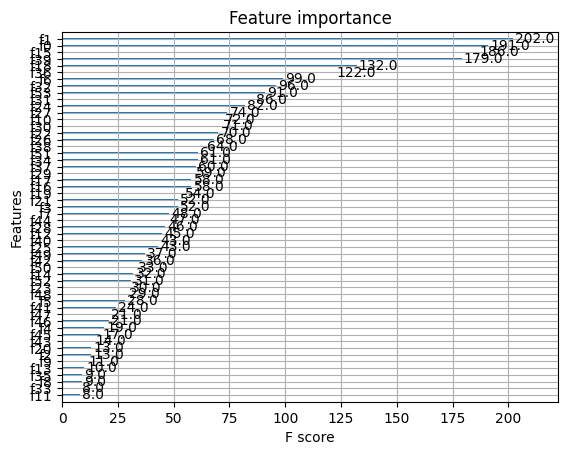

In [7]:
# feature importance
xgb.plot_importance(selector.estimator_)

In [9]:
# release memory
gc.collect()

576

# Hyperparameters Tuning

## ElasticNet

In [ ]:
%%time
from sklearn.linear_model import ElasticNet
seed = 42 # Set the seed

# Initialize the Regressor with desired hyperparameters
regr = ElasticNet(random_state=42)

tscv = TimeSeriesSplit(n_splits=5)  # provides train/test indices to split time series data samples

hyperparameters = {
    'alpha' : (0, 0.5, 1),
    'l1_ratio':(0, 0.5, 1),
    'max_iter': (100, 200, 500)
} 

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    regr, hyperparameters, scoring=score, cv=tscv, verbose=3
) # Grid search
grid_search.fit(X_train.astype('float32').fillna(method='ffill').fillna(0), y_train) # search in the training data
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END alpha=0, l1_ratio=0, max_iter=100;, score=-7.032 total time=   3.6s
[CV 2/5] END alpha=0, l1_ratio=0, max_iter=100;, score=-7.051 total time=   6.8s
[CV 3/5] END alpha=0, l1_ratio=0, max_iter=100;, score=-6.659 total time=  11.1s
[CV 4/5] END alpha=0, l1_ratio=0, max_iter=100;, score=-6.152 total time=  15.1s
[CV 5/5] END alpha=0, l1_ratio=0, max_iter=100;, score=-6.389 total time=  19.9s
[CV 1/5] END alpha=0, l1_ratio=0, max_iter=200;, score=-7.032 total time=   6.4s
[CV 2/5] END alpha=0, l1_ratio=0, max_iter=200;, score=-7.051 total time=  13.1s
[CV 3/5] END alpha=0, l1_ratio=0, max_iter=200;, score=-6.660 total time=  20.8s
[CV 4/5] END alpha=0, l1_ratio=0, max_iter=200;, score=-6.152 total time=  28.6s
[CV 5/5] END alpha=0, l1_ratio=0, max_iter=200;, score=-6.389 total time=  36.9s
[CV 1/5] END alpha=0, l1_ratio=0, max_iter=500;, score=-7.032 total time=  17.0s
[CV 2/5] END alpha=0, l1_ratio=0, max_iter=500;

ElasticNet(alpha=0, l1_ratio=0, max_iter=100, random_state=42)

CPU times: user 41min 29s, sys: 24min 44s, total: 1h 6min 13s
Wall time: 1h 6min 13s


In [ ]:
grid_search.cv_results_['params']

[{'alpha': 0, 'l1_ratio': 0, 'max_iter': 100},
 {'alpha': 0, 'l1_ratio': 0, 'max_iter': 200},
 {'alpha': 0, 'l1_ratio': 0, 'max_iter': 500},
 {'alpha': 0, 'l1_ratio': 0.5, 'max_iter': 100},
 {'alpha': 0, 'l1_ratio': 0.5, 'max_iter': 200},
 {'alpha': 0, 'l1_ratio': 0.5, 'max_iter': 500},
 {'alpha': 0, 'l1_ratio': 1, 'max_iter': 100},
 {'alpha': 0, 'l1_ratio': 1, 'max_iter': 200},
 {'alpha': 0, 'l1_ratio': 1, 'max_iter': 500},
 {'alpha': 0.5, 'l1_ratio': 0, 'max_iter': 100},
 {'alpha': 0.5, 'l1_ratio': 0, 'max_iter': 200},
 {'alpha': 0.5, 'l1_ratio': 0, 'max_iter': 500},
 {'alpha': 0.5, 'l1_ratio': 0.5, 'max_iter': 100},
 {'alpha': 0.5, 'l1_ratio': 0.5, 'max_iter': 200},
 {'alpha': 0.5, 'l1_ratio': 0.5, 'max_iter': 500},
 {'alpha': 0.5, 'l1_ratio': 1, 'max_iter': 100},
 {'alpha': 0.5, 'l1_ratio': 1, 'max_iter': 200},
 {'alpha': 0.5, 'l1_ratio': 1, 'max_iter': 500},
 {'alpha': 1, 'l1_ratio': 0, 'max_iter': 100},
 {'alpha': 1, 'l1_ratio': 0, 'max_iter': 200},
 {'alpha': 1, 'l1_ratio': 0, '

### Plot how loss decrease with the max iteratino

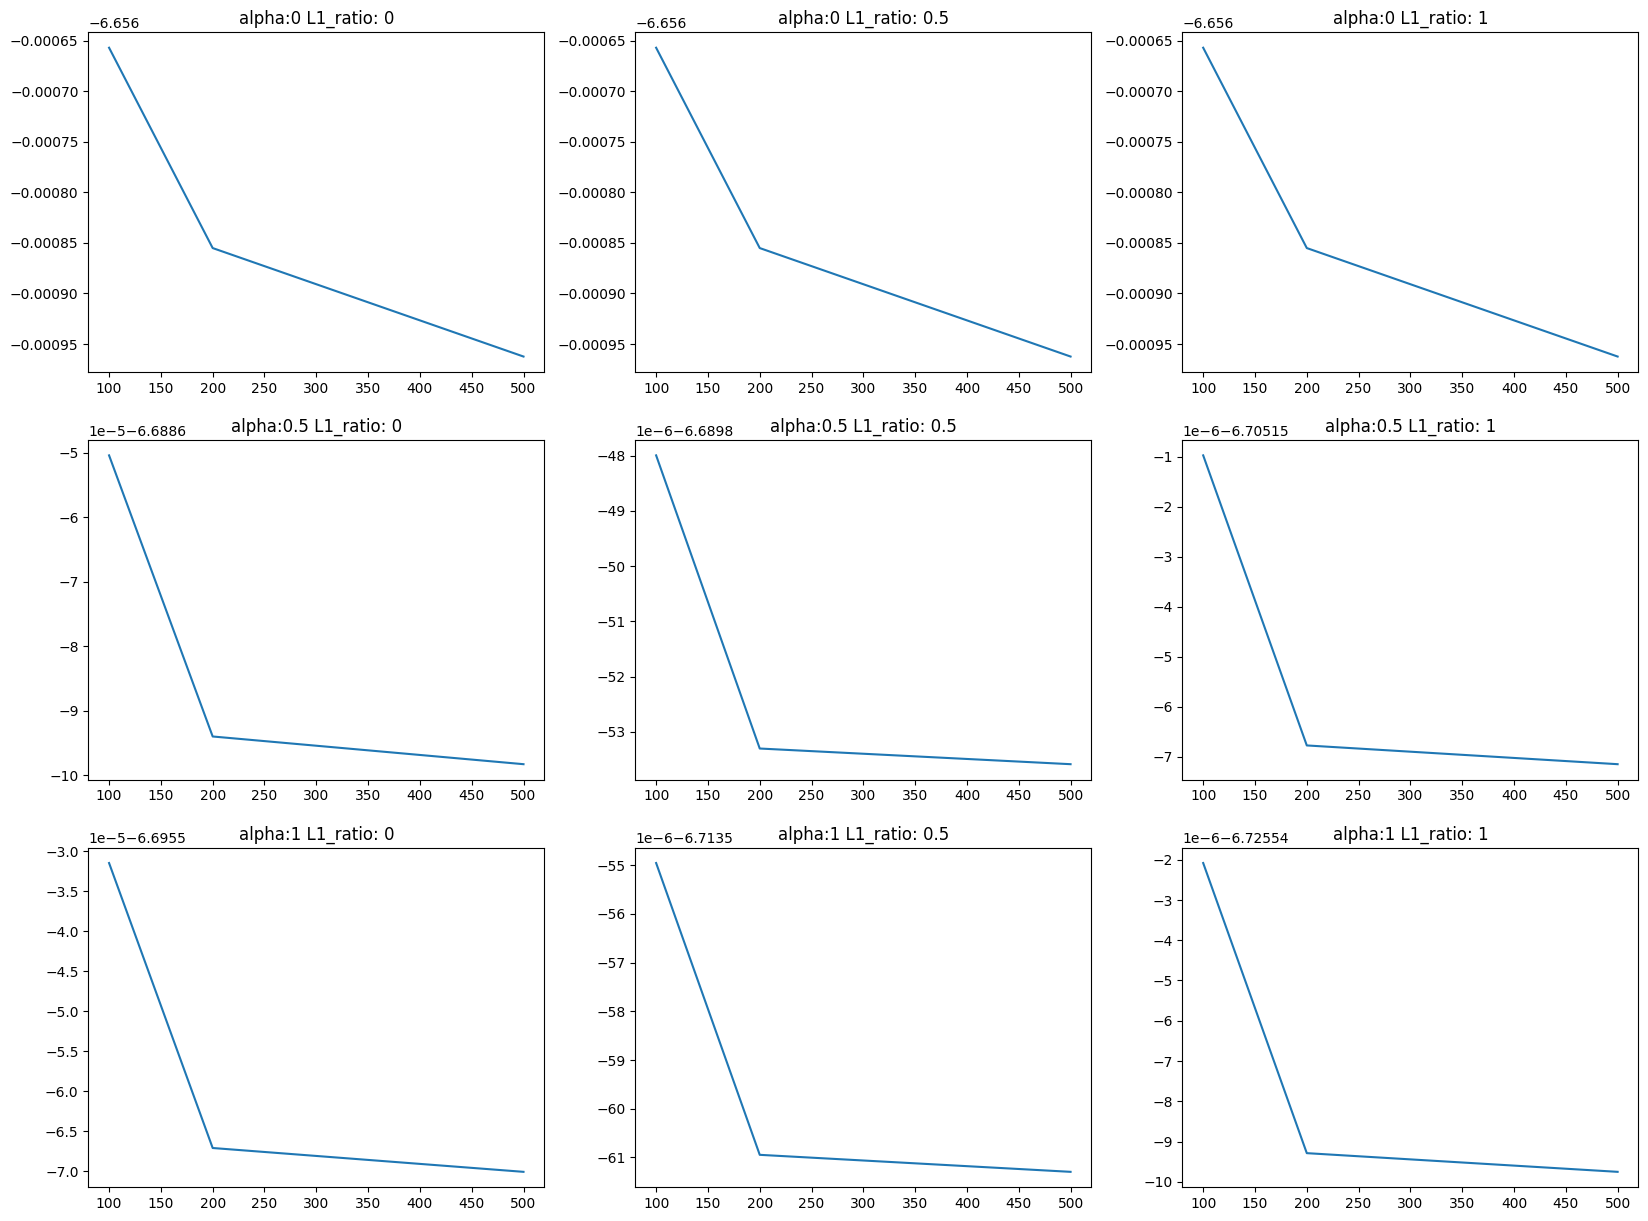

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(20,15))
paras = grid_search.cv_results_['params']
for i in range(9):
    ax[i//3,i%3].plot((100,200,500),grid_search.cv_results_['mean_test_score'][i*3:i*(3)+3])
    ax[i//3,i%3].set_title(f"alpha:{paras[i*3]['alpha']} L1_ratio: {paras[i*3]['l1_ratio']}")

## XGBoost

### First Phase

First I will tune the most important hyperparameters which may have great impach on the model performance.

Here, I pick the `n_estimators` and `learning_rate`.

In [10]:
%%time
seed = 42 # Set the seed

# Initialize the XGBRegressor with desired hyperparameters
bst_xgb = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    random_state=seed,
    verbosity=0,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)  # provides train/test indices to split time series data samples

hyperparameters = {
    'n_estimators' : (50, 100, 200),
    'learning_rate':(0.01,0.1,0.3),
} # The best is 100, 0.1

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_xgb, hyperparameters, scoring=score, cv=tscv, verbose=3
) # Grid search
grid_search.fit(X_train, y_train) # search in the training data
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=-7.391 total time=  25.3s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=-6.846 total time=  53.0s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=-6.147 total time= 1.5min
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=-6.381 total time= 2.1min
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=-5.947 total time= 2.9min
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=-7.354 total time=  43.4s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=-6.821 total time= 1.6min
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=-6.132 total time= 2.7min
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=-6.365 total time= 4.0min
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=-5.930 total time= 5.1min
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=-7.325 total time= 1.3min
[CV 2/5] END learning

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

CPU times: user 6h 12min 59s, sys: 2min 3s, total: 6h 15min 2s
Wall time: 2h 38min 14s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

{'learning_rate': 0.1, 'n_estimators': 100}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

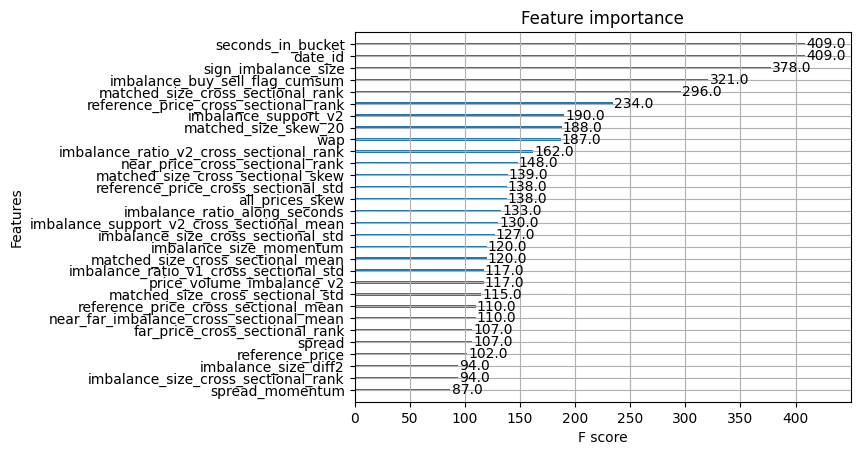

In [21]:
# Show the results
display(grid_search.best_estimator_)
display(grid_search.best_params_)
xgb.plot_importance(grid_search.best_estimator_,max_num_features=30) 

In [14]:
# release memory
gc.collect()

70

### Second Phase

Next, I'm going to tune `max_depth` and `colsample_bynode`.

In [22]:
%%time
seed = 42 # Set the seed

# Initialize the XGBRegressor with desired hyperparameters
bst_xgb = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 100,
    learning_rate = 0.1,
    random_state=seed,
    verbosity=0,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)  # provides train/test indices to split time series data samples

hyperparameters = {
    'max_depth' : (3, 6, 9),
    'colsample_bynode':(0.5, 0.65, 0.8),
} 

# max_depth: 6 colsample_bynode: 0.8

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_xgb, hyperparameters, scoring=score, cv=tscv, verbose=3
) # Grid search
grid_search.fit(X_train, y_train) # search in the training data
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END colsample_bynode=0.5, max_depth=3;, score=-7.317 total time=  45.0s
[CV 2/5] END colsample_bynode=0.5, max_depth=3;, score=-6.798 total time= 1.8min
[CV 3/5] END colsample_bynode=0.5, max_depth=3;, score=-6.121 total time= 3.1min
[CV 4/5] END colsample_bynode=0.5, max_depth=3;, score=-6.347 total time= 4.6min
[CV 5/5] END colsample_bynode=0.5, max_depth=3;, score=-5.914 total time= 6.1min
[CV 1/5] END colsample_bynode=0.5, max_depth=6;, score=-7.316 total time=  48.3s
[CV 2/5] END colsample_bynode=0.5, max_depth=6;, score=-6.774 total time= 1.8min
[CV 3/5] END colsample_bynode=0.5, max_depth=6;, score=-6.107 total time= 3.0min
[CV 4/5] END colsample_bynode=0.5, max_depth=6;, score=-6.328 total time= 4.1min
[CV 5/5] END colsample_bynode=0.5, max_depth=6;, score=-5.898 total time= 5.7min
[CV 1/5] END colsample_bynode=0.5, max_depth=9;, score=-7.333 total time=  48.6s
[CV 2/5] END colsample_bynode=0.5, max_depth=9;, 

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.8,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

CPU times: user 5h 16min 55s, sys: 1min 7s, total: 5h 18min 2s
Wall time: 2h 17min 13s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.8,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

{'colsample_bynode': 0.8, 'max_depth': 6}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

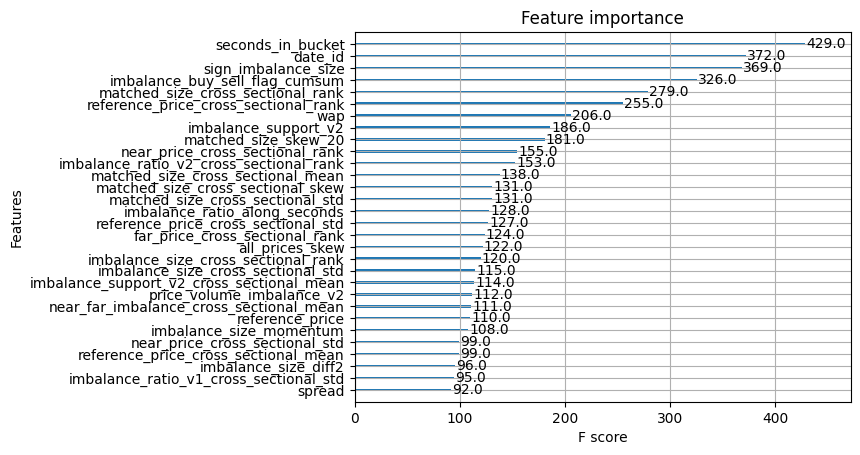

In [23]:
display(grid_search.best_estimator_)
display(grid_search.best_params_)
xgb.plot_importance(grid_search.best_estimator_,max_num_features=30) 

## LightGBM

### First Phase

In [26]:
%%time
from lightgbm import LGBMRegressor
import lightgbm as lgb

bst_lgb = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    random_state=42,
#     device= "cuda"
)

tscv = TimeSeriesSplit(n_splits=5)  # provides train/test indices to split time series data samples

hyperparameters = {
    'n_estimators': (50, 75, 100),
    'learning_rate':(0.01,0.1,0.3),
} # 'learning_rate': 0.1, 'n_estimators': 100

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_lgb, hyperparameters, scoring=score, cv=tscv,verbose=3
) # Grid search
grid_search.fit(X_train, y_train) # search in the training data
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_params_)
display(grid_search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=-7.394 total time=  17.6s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=-6.848 total time=  32.3s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=-6.148 total time=  47.4s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=-6.381 total time= 1.0min
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=-5.947 total time= 1.3min
[CV 1/5] END learning_rate=0.01, n_estimators=75;, score=-7.373 total time=  24.9s
[CV 2/5] END learning_rate=0.01, n_estimators=75;, score=-6.834 total time=  44.3s
[CV 3/5] END learning_rate=0.01, n_estimators=75;, score=-6.139 total time= 1.1min
[CV 4/5] END learning_rate=0.01, n_estimators=75;, score=-6.372 total time= 1.4min
[CV 5/5] END learning_rate=0.01, n_estimators=75;, score=-5.938 total time= 1.7min
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=-7.359 total time=  31.5s
[CV 2/5] END learning_rate

LGBMRegressor(objective='mae', random_state=42)

CPU times: user 2h 19min 11s, sys: 1min, total: 2h 20min 12s
Wall time: 42min 7s


In [27]:
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_params_)
display(grid_search.best_estimator_)

Grid search best MAE: -6.48689289540571


{'learning_rate': 0.1, 'n_estimators': 100}

LGBMRegressor(objective='mae', random_state=42)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

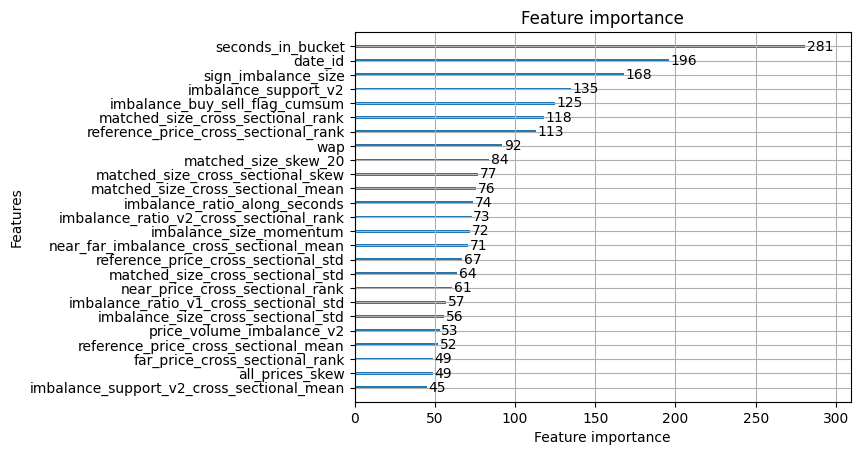

In [34]:
lgb.plot_importance(grid_search.best_estimator_,max_num_features=25)

### Second Phase

In [35]:
%%time
from lightgbm import LGBMRegressor
import lightgbm as lgb

bst_lgb = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    learning_rate = 0.1,
    n_estimators = 100,
    random_state=42,
#     device= "cuda"
)

tscv = TimeSeriesSplit(n_splits=5)  # provides train/test indices to split time series data samples

hyperparameters = {
    'num_leaves' : (30, 40, 50),
    'colsample_bytree':(0.5, 0.65, 0.8),
} # 'colsample_bytree': 0.5, 'num_leaves': 50

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_lgb, hyperparameters, scoring=score, cv=tscv,verbose=3
) # Grid search
grid_search.fit(X_train, y_train) # search in the training data
print(f'Grid search best MAE: {grid_search.best_score_}')
display(grid_search.best_params_)
display(grid_search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END colsample_bytree=0.5, num_leaves=30;, score=-7.305 total time=  19.2s
[CV 2/5] END colsample_bytree=0.5, num_leaves=30;, score=-6.782 total time=  32.8s
[CV 3/5] END colsample_bytree=0.5, num_leaves=30;, score=-6.111 total time=  44.0s
[CV 4/5] END colsample_bytree=0.5, num_leaves=30;, score=-6.332 total time=  58.4s
[CV 5/5] END colsample_bytree=0.5, num_leaves=30;, score=-5.902 total time= 1.3min
[CV 1/5] END colsample_bytree=0.5, num_leaves=40;, score=-7.303 total time=  20.3s
[CV 2/5] END colsample_bytree=0.5, num_leaves=40;, score=-6.779 total time=  35.3s
[CV 3/5] END colsample_bytree=0.5, num_leaves=40;, score=-6.111 total time=  47.9s
[CV 4/5] END colsample_bytree=0.5, num_leaves=40;, score=-6.333 total time= 1.0min
[CV 5/5] END colsample_bytree=0.5, num_leaves=40;, score=-5.899 total time= 1.3min
[CV 1/5] END colsample_bytree=0.5, num_leaves=50;, score=-7.306 total time=  20.7s
[CV 2/5] END colsample_bytr

{'colsample_bytree': 0.5, 'num_leaves': 50}

LGBMRegressor(colsample_bytree=0.5, num_leaves=50, objective='mae',
              random_state=42)

CPU times: user 2h 15min 33s, sys: 1min 12s, total: 2h 16min 46s
Wall time: 42min 22s


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

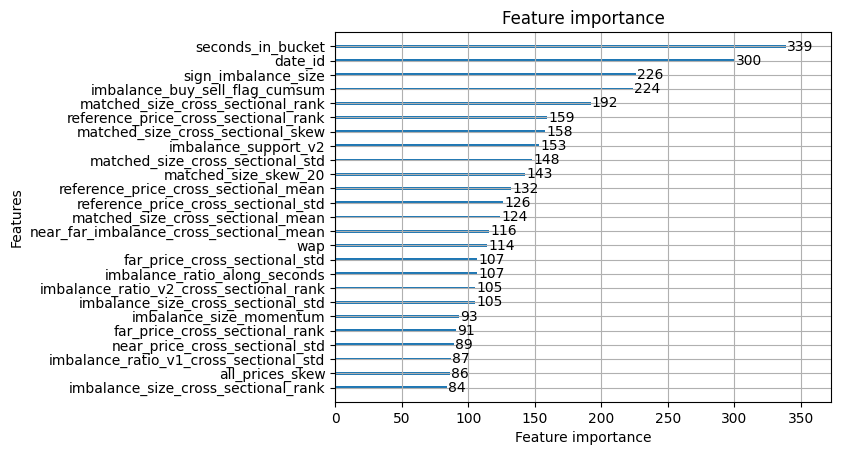

In [36]:
lgb.plot_importance(grid_search.best_estimator_,max_num_features=25)

## MLP

### Contrust dataset

In [ ]:
class NNDataset(Dataset):
    '''Dataset for Neural Net.'''
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): 
        data = self.df.iloc[idx,:].to_numpy()
        label = self.labels[idx].to_num()
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()

In [ ]:
# Construct dataset
df_train_nn = df_train.astype('float32').fillna(method='ffill').fillna(0)
df_train_nn = reduce_mem_usage(df_train_nn, verbose=0)
X_train, X_test, y_train, y_test = train_test_split(df_train_nn, target_train, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

train_dataset = TensorDataset(torch.from_numpy(X_train.to_numpy()),torch.from_numpy(y_train.to_numpy()))
val_dataset = TensorDataset(torch.from_numpy(X_val.to_numpy()),torch.from_numpy(y_val.to_numpy()))
test_dataset = TensorDataset(torch.from_numpy(X_test.to_numpy()),torch.from_numpy(y_test.to_numpy()))

# Batch size
batch_size = 200

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,pin_memory=True)

### Train and test function

In [ ]:
# train 
def train(model, data_loader, loss_fn, optimizer, device):
    # train mode
    model.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(data_loader):
        x = x.to(device)
        y = y.to(device)
        loss = 0
        pred_y = model(x)
        loss += loss_fn(pred_y,y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # sum up all the batch loss 
        train_loss += loss.item()
        if batch_idx % (len(data_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(data_loader), train_loss/(batch_idx+1)))
    return train_loss

# test or validation
def evaluate(model, data_loader, loss_fn, device):
    # evaluation mode
    model.eval()
    eval_loss = 0 # loss
    with torch.no_grad():
        for batch, (x, y) in enumerate(data_loader):
            x = x.to(device)
            y = y.to(device)
            loss = 0
            pred_y = model(x)
            loss += loss_fn(pred_y,y)
            # sum up all the batch loss 
            eval_loss += loss.item()
            
    return eval_loss

### ReLU activation 

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_feature):
        super(MLP, self).__init__()
        self.Input = nn.Sequential(
            nn.Linear(n_feature,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1))
    def forward(self, x):
        out = self.Input(x)
        return out

In [ ]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

# parameters
num_epochs = 50
lr = 1e-3
lr_decay = 0.1
train_losses = []
val_losses = []

# loss function
loss_fn = nn.SmoothL1Loss()

# Model
n_features = df_train.shape[1]
model=MLP(n_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=lr_decay)

start = 1 
for epoch in tqdm.tqdm(range(start, num_epochs + start)):
    train_loss = train(model,train_dataloader,loss_fn,optimizer,device)
    val_loss = evaluate(model,val_dataloader,loss_fn,device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch[{epoch}]: train loss {train_loss}')
    print(f'Epoch[{epoch}]: validation loss {val_loss}')
#     scheduler.step()

#     checkpoint = {  "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "epoch": epoch}
#     path_checkpoint = "checkpoint_{}_epoch".format(epoch)
#     torch.save(checkpoint, path_checkpoint)

In [ ]:
checkpoint_path = "checkpoint_{}_epoch".format('ReLU')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
evaluate(model, test_dataloader, loss_fn, device)

16120196878.873621

In [ ]:
from sklearn.metrics import mean_absolute_error

# evaluation mode
model.eval()
eval_loss = 0 # loss
n = 0
with torch.no_grad():
    for batch, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)
        eval_loss += mean_absolute_error(y.cpu(),pred_y.cpu().detach())
        n+=1
            
mae_MLP = eval_loss/n
print(f"ElasticNet's MAE is {mae_MLP:.3f}")
mae_MLP

In [ ]:
def plot_comparision(first_metric,second_metric, num_epochs, ax, title=None,left_label=None,right_label=None):
    color = 'tab:blue'
    ax.set_xlabel('Epoch')
    if left_label:
        ax.set_ylabel(f'{left_label}', color=color)
    ax.plot(range(1, num_epochs + 1), first_metric, color=color)
    ax.tick_params(axis='y', labelcolor=color)

    if second_metric:
        ax = ax.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        if right_label:
            ax.set_ylabel(f'{right_label}', color=color)  # we already handled the x-label with ax1
        ax.plot(range(1, num_epochs + 1), second_metric, color=color)
        ax.tick_params(axis='y', labelcolor=color)

    if title:
        ax.set_title(title)
        
title1 = "Loss"
fig = plt.figure(figsize=(5,3))
ax1 = fig.add_subplot() 
plot_comparision(train_losses,val_losses, num_epochs, ax1,title1,'Training Loss','Val Losses')
fig.tight_layout()
plt.show()

### LeakyReLU activation 

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_feature):
        super(MLP, self).__init__()
        self.Input = nn.Sequential(
            nn.Linear(n_feature,64),
            nn.LeakyReLU(),
            nn.Linear(64,32),
            nn.LeakyReLU(),
            nn.Linear(32,1))
    def forward(self, x):
        out = self.Input(x)
        return out

In [ ]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

# parameters
num_epochs = 50
lr = 1e-3
lr_decay = 0.1
train_losses = []
val_losses = []

# loss function
loss_fn = nn.SmoothL1Loss()

# Model
n_features = df_train.shape[1]
model=MLP(n_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=lr_decay)

start = 1 
for epoch in tqdm.tqdm(range(start, num_epochs + start)):
    train_loss = train(model,train_dataloader,loss_fn,optimizer,device)
    val_loss = evaluate(model,val_dataloader,loss_fn,device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch[{epoch}]: train loss {train_loss}')
    print(f'Epoch[{epoch}]: validation loss {val_loss}')
#     scheduler.step()

#     checkpoint = {  "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "epoch": epoch}
#     path_checkpoint = "checkpoint_{}_epoch".format(epoch)
#     torch.save(checkpoint, path_checkpoint)

In [ ]:
checkpoint_path = "checkpoint_{}_epoch".format('LeakyReLU')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
evaluate(model, test_dataloader, loss_fn, device)

34289.451211501146

In [ ]:
def plot_comparision(first_metric,second_metric, num_epochs, ax, title=None,left_label=None,right_label=None):
    color = 'tab:blue'
    ax.set_xlabel('Epoch')
    if left_label:
        ax.set_ylabel(f'{left_label}', color=color)
    ax.plot(range(1, num_epochs + 1), first_metric, color=color)
    ax.tick_params(axis='y', labelcolor=color)

    if second_metric:
        ax = ax.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        if right_label:
            ax.set_ylabel(f'{right_label}', color=color)  # we already handled the x-label with ax1
        ax.plot(range(1, num_epochs + 1), second_metric, color=color)
        ax.tick_params(axis='y', labelcolor=color)

    if title:
        ax.set_title(title)
        
title1 = "Loss"
fig = plt.figure(figsize=(5,3))
ax1 = fig.add_subplot() 
plot_comparision(train_losses,val_losses, num_epochs, ax1,title1,'Training Loss','Val Losses')
fig.tight_layout()
plt.show()

# Model Training ant Testing

## Elastic Net

### Train

In [ ]:
seed = 42 # Set the seed

# Initialize the Regressor with desired hyperparameters
regr = ElasticNet(alpha=0, l1_ratio=0, max_iter=100, random_state=42)
regr.fit(X_train.astype('float32').fillna(method='ffill').fillna(0),y_train)

ElasticNet(alpha=0, l1_ratio=0, max_iter=100, random_state=42)

### Test

In [ ]:
from sklearn.metrics import mean_absolute_error
pred_y = regr.predict(X_test.astype('float32').fillna(method='ffill').fillna(0))
mae_regr = mean_absolute_error(y_test,pred_y)
print(f"ElasticNet's MAE is {mae_regr:.3f}")
mae_regr

ElasticNet's MAE is 6.018


6.017632670611946

### Feature Importance

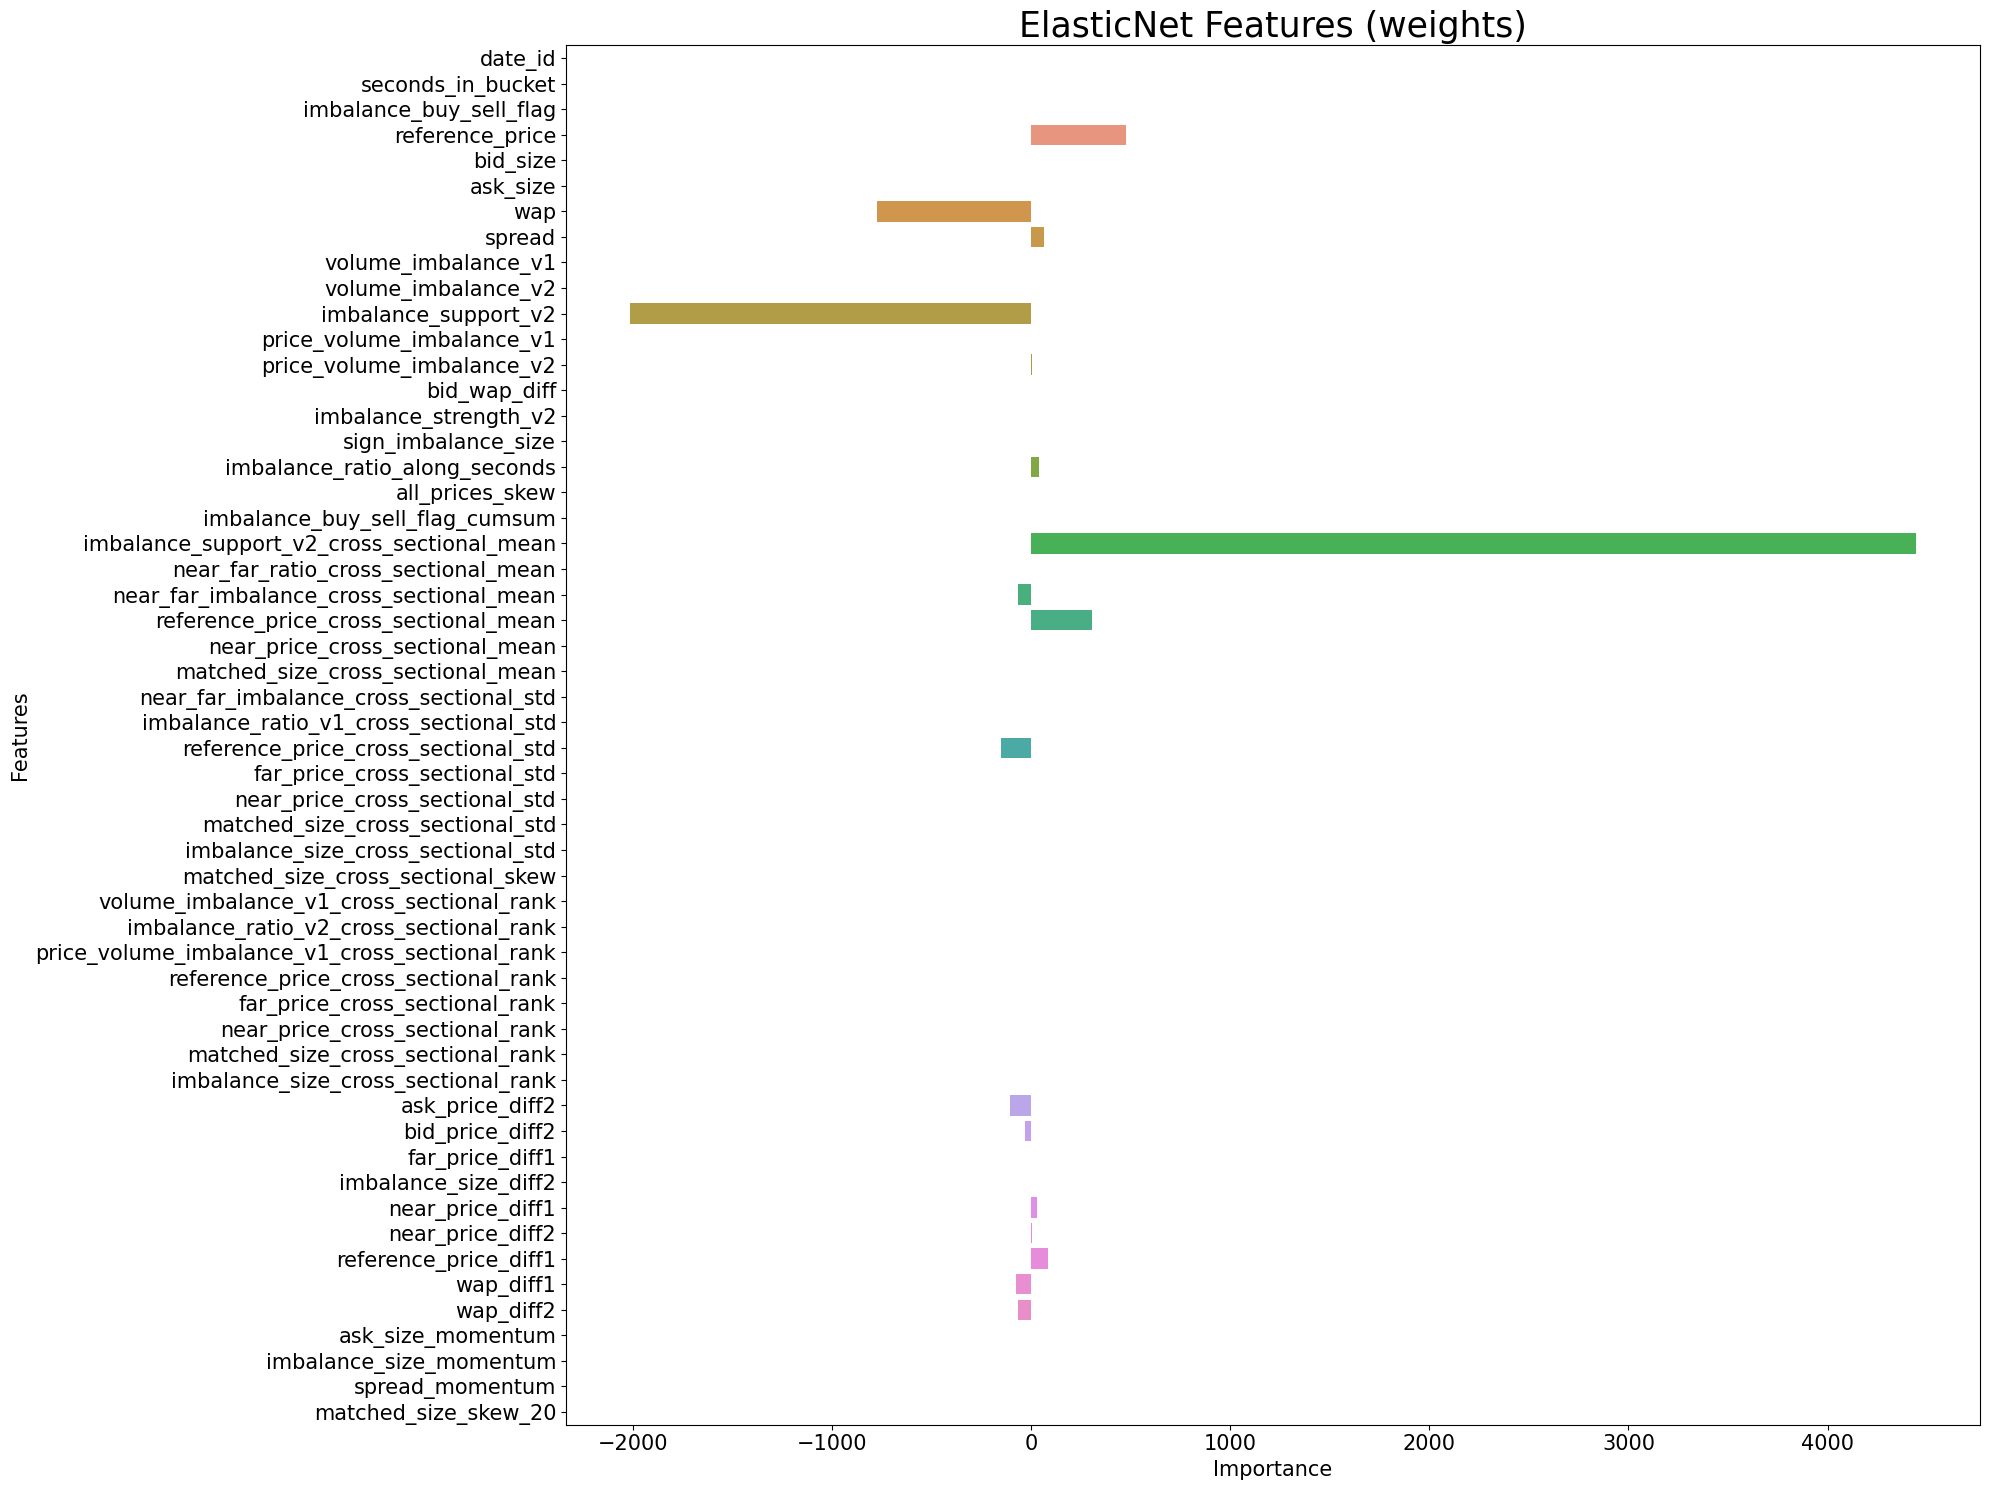

In [ ]:
feature_importance = pd.DataFrame(regr.coef_,index = regr.feature_names_in_,columns = ['score'])
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features','Importance']
plt.figure(figsize=(20, 15))
f = sns.barplot(x="Importance", y="Features", data=feature_importance)
# f.axes.set_title("Title",fontsize=50)
f.set_xlabel("Importance",fontsize=15)
f.set_ylabel("Features",fontsize=15)
f.tick_params(labelsize=15)
plt.title(f'ElasticNet Features (weights)',fontsize=25)
plt.tight_layout()
plt.show()

## XGBoost

### Train

In [ ]:
%%time
seed = 42 # Set the seed

# Initialize the XGBRegressor with desired hyperparameters
bst_xgb = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 100,
    learning_rate = 0.1,
    colsample_bynode = 0.8,
    max_depth = 6,
    random_state=seed,
    verbosity=3,
#     device='cuda'
)
bst_xgb.fit(X_train, y_train)

[06:40:35] ======== Monitor (0): HostSketchContainer ========
[06:40:35] AllReduce: 0.03683s, 1 calls @ 36830us

[06:40:35] MakeCuts: 0.037003s, 1 calls @ 37003us

[06:40:35] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[06:43:15] ======== Monitor (0): Learner ========
[06:43:15] Configure: 0.000578s, 1 calls @ 578us

[06:43:15] EvalOneIter: 0.00153s, 100 calls @ 1530us

[06:43:15] GetGradient: 2.12652s, 100 calls @ 2126516us

[06:43:15] PredictRaw: 0.001794s, 100 calls @ 1794us

[06:43:15] UpdateOneIter: 160.185s, 100 calls @ 160185049us

[06:43:15] ======== Monitor (0): GBTree ========
[06:43:15] BoostNewTrees: 157.491s, 100 calls @ 157491041us

[06:43:15] CommitModel: 0.000168s, 100 calls @ 168us

[06:43:15] ======== Monitor (0): HistUpdater ========
[06:43:15] BuildHistogram: 13.1413s, 500 calls @ 13141276us

[06:43:15] EvaluateSplits: 0.745503s, 600 calls @ 745503us

[06:43:15] InitData: 0.336795s, 100 calls @ 336795us

[06:43:15] InitRoot: 14.6713s, 100 calls @ 1

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.8,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

### Test

In [ ]:
from sklearn.metrics import mean_absolute_error
pred_y = bst_xgb.predict(X_test)
mae_xgboost = mean_absolute_error(y_test,pred_y)
print(f"XGboost's MAE is {mae_xgboost:.3f}")
mae_xgboost

XGboost's MAE is 5.970


5.970286832981401

### Feature Importance

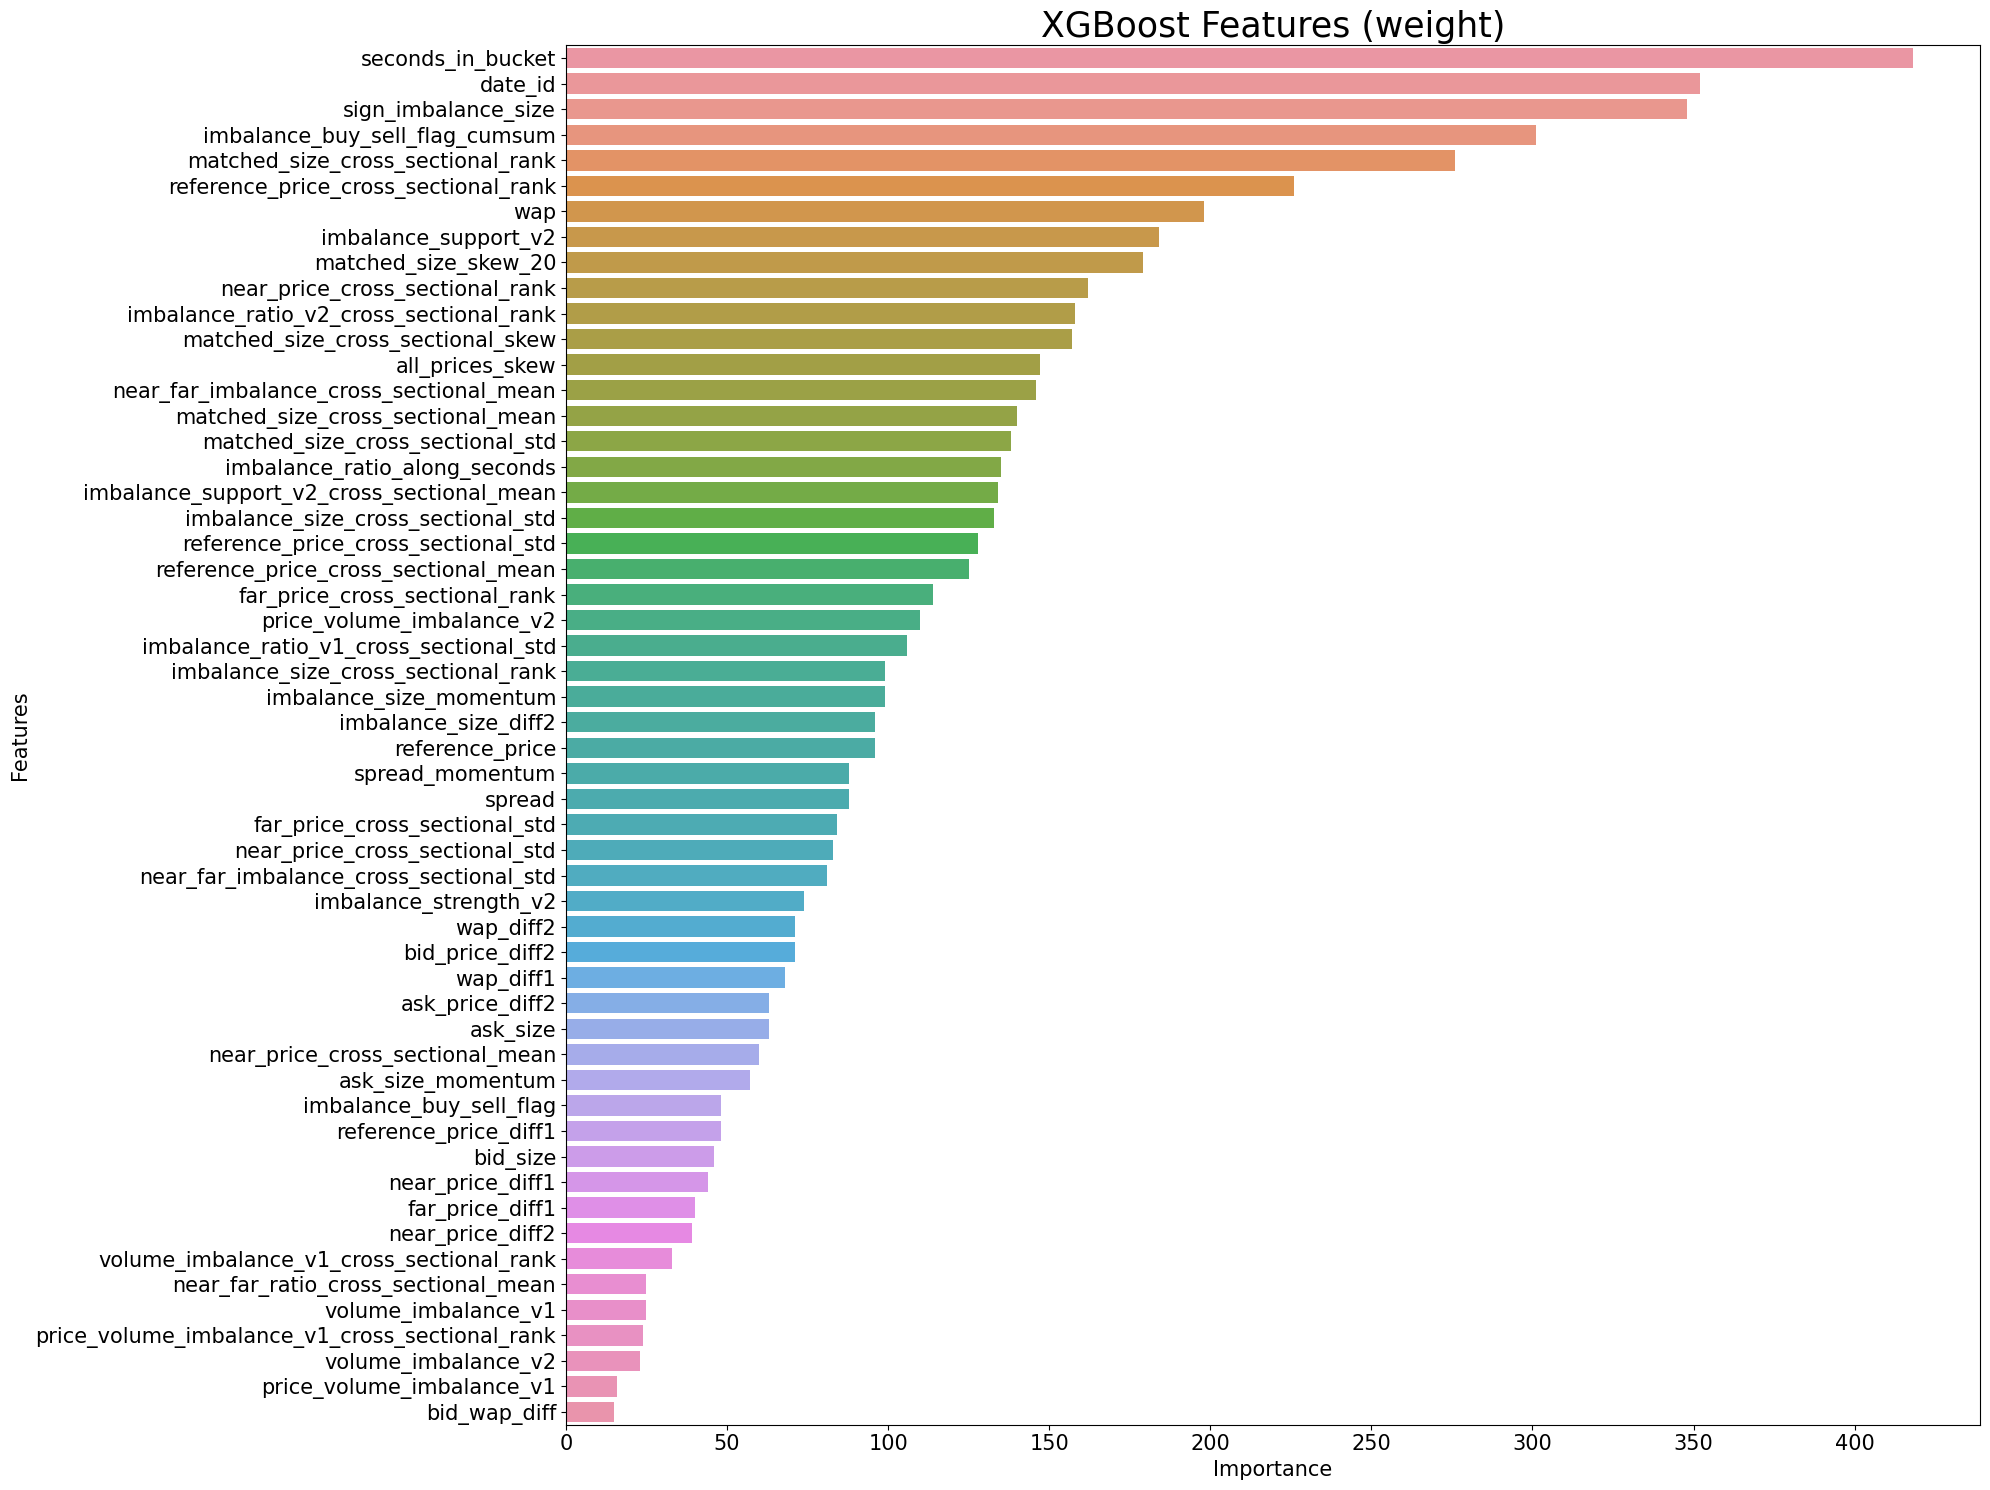

In [ ]:
metric = 'weight'  # weight, gain, cover, total_gain, total_cover
imp = bst_xgb.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp,index=['score']).T.sort_values('score',ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features','Importance']
plt.figure(figsize=(20, 15))
f = sns.barplot(x="Importance", y="Features", data=feature_importance)
# f.axes.set_title("Title",fontsize=50)
f.set_xlabel("Importance",fontsize=15)
f.set_ylabel("Features",fontsize=15)
f.tick_params(labelsize=15)
plt.title(f'XGBoost Features ({metric})',fontsize=25)
plt.tight_layout()
plt.show()

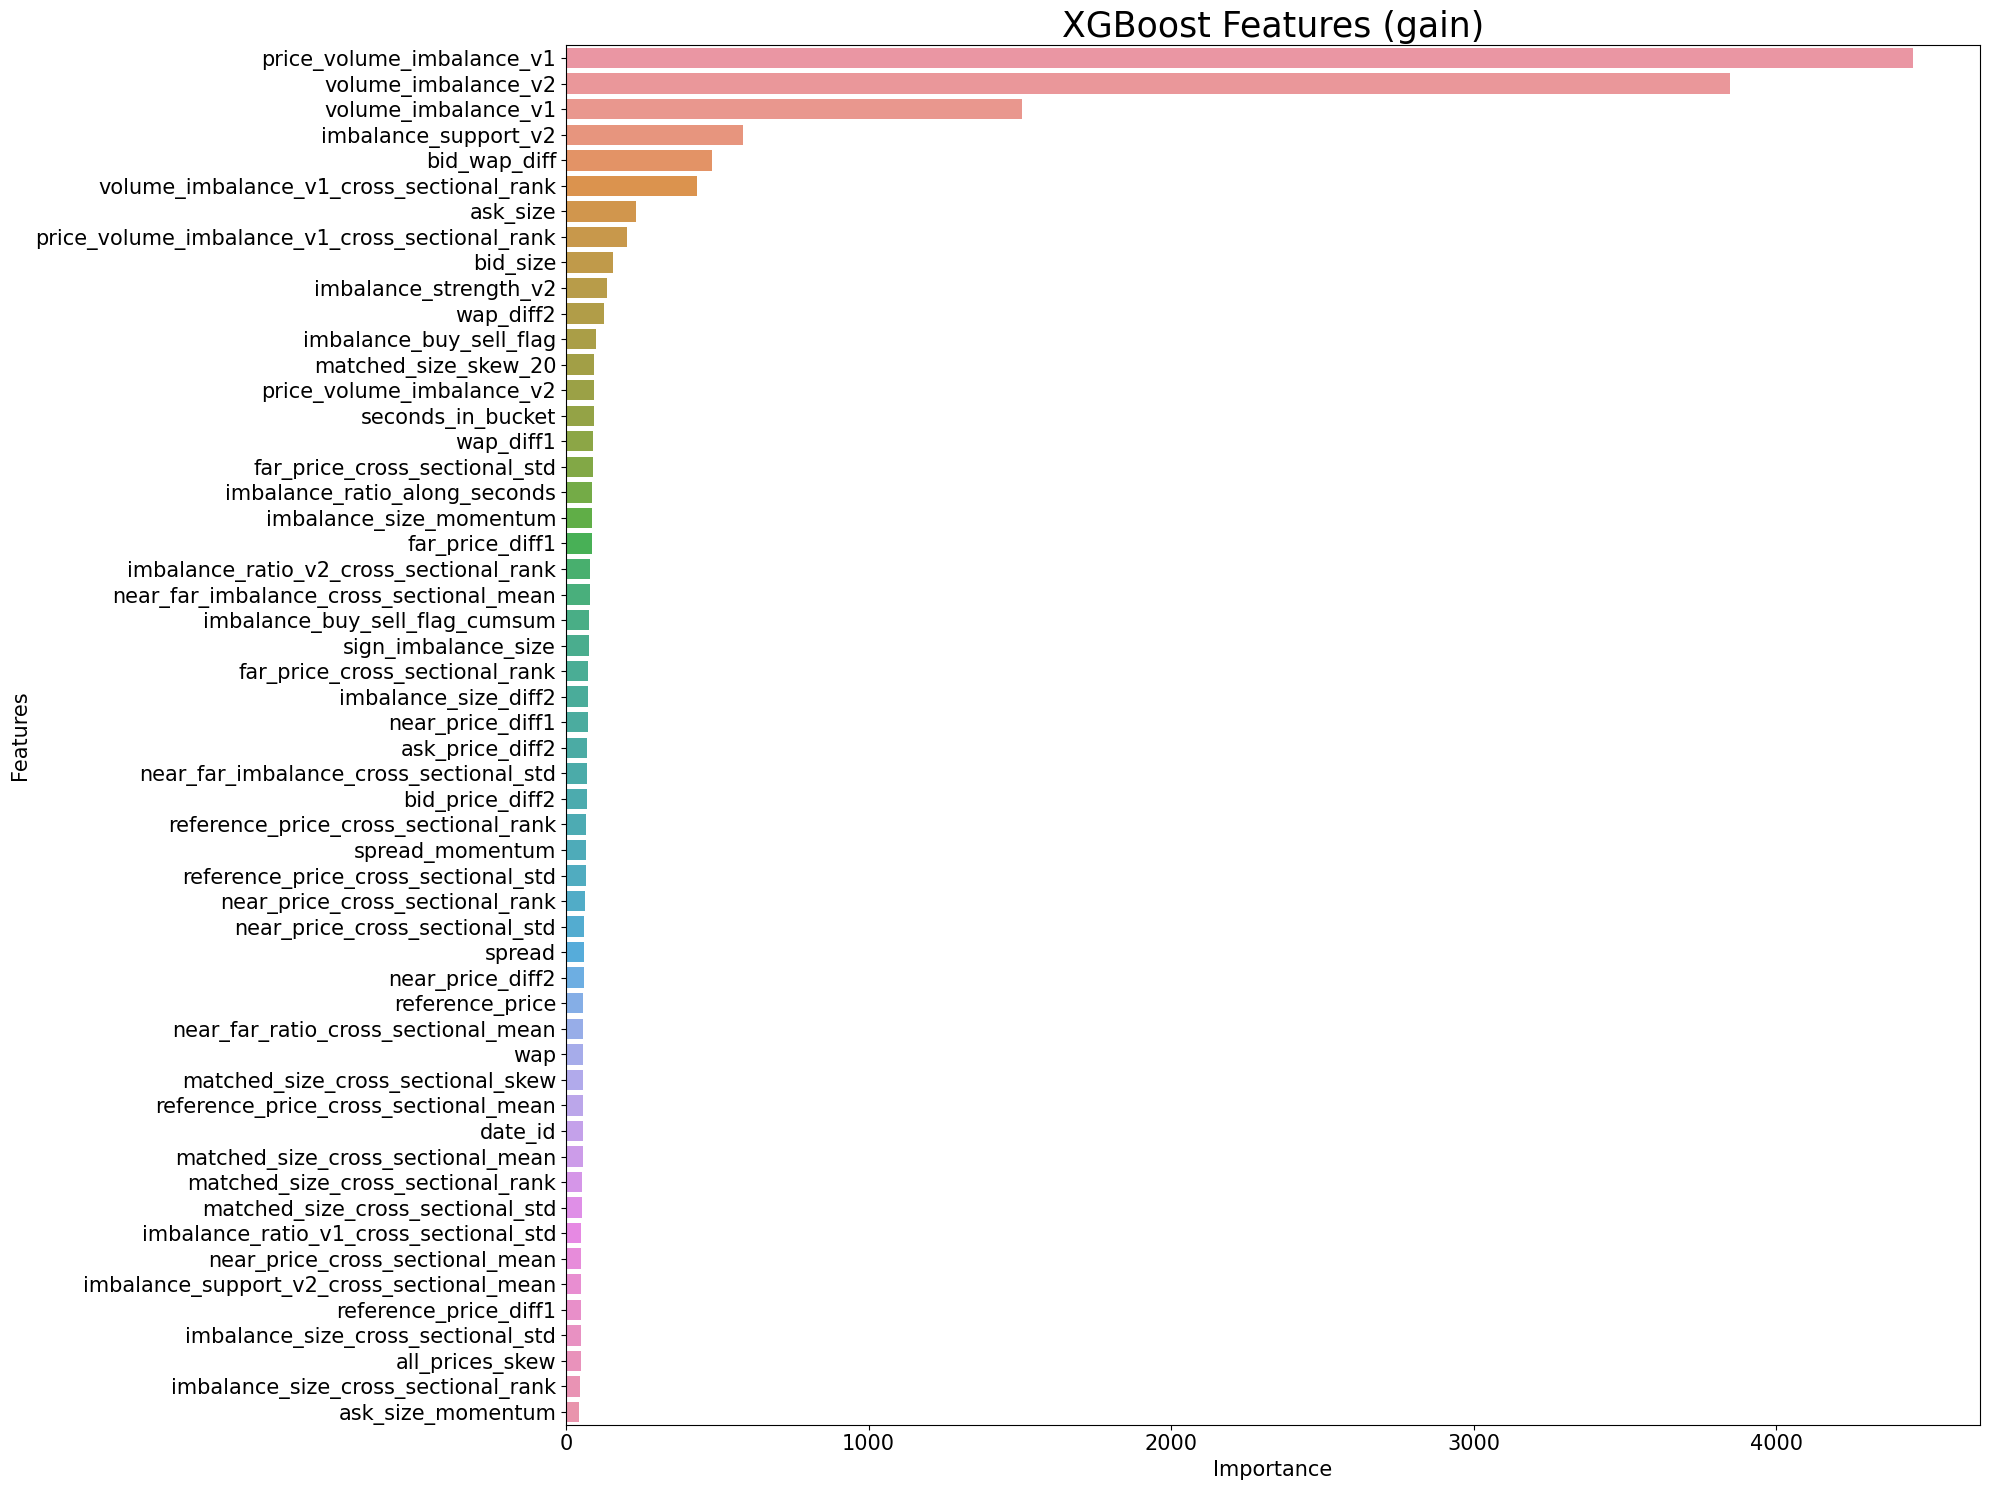

In [ ]:
metric = 'gain'  # weight, gain, cover, total_gain, total_cover
imp = bst_xgb.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp,index=['score']).T.sort_values('score',ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features','Importance']
plt.figure(figsize=(20, 15))
f = sns.barplot(x="Importance", y="Features", data=feature_importance)
# f.axes.set_title("Title",fontsize=50)
f.set_xlabel("Importance",fontsize=15)
f.set_ylabel("Features",fontsize=15)
f.tick_params(labelsize=15)
plt.title(f'XGBoost Features ({metric})',fontsize=25)
plt.tight_layout()
plt.show()

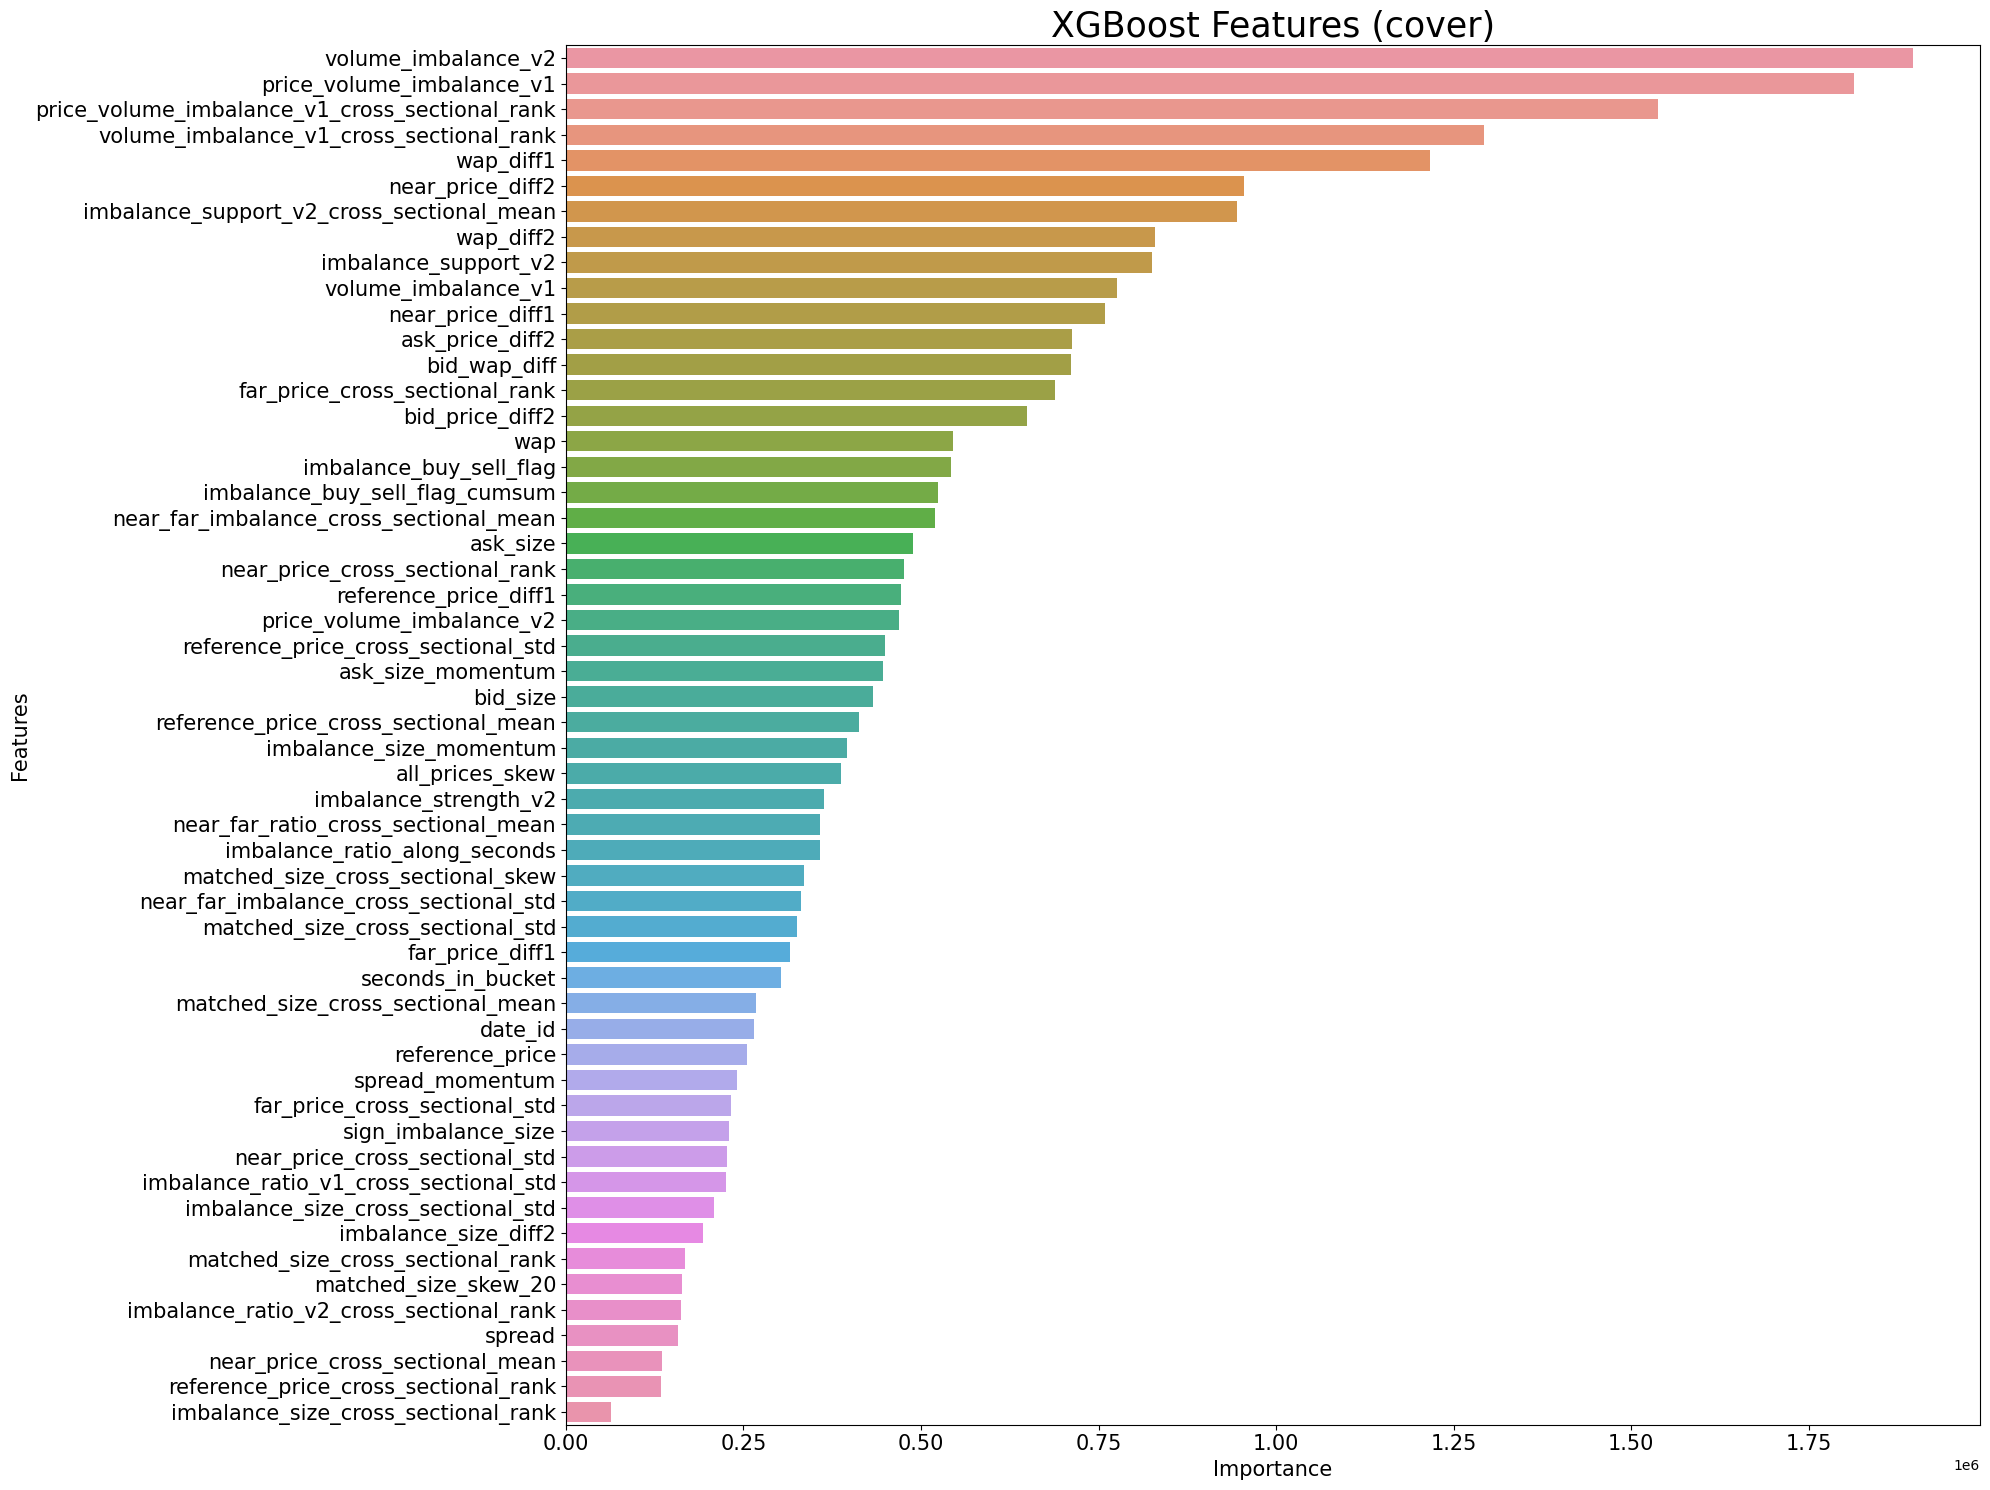

In [ ]:
metric = 'cover'  # weight, gain, cover, total_gain, total_cover
imp = bst_xgb.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp,index=['score']).T.sort_values('score',ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features','Importance']
plt.figure(figsize=(20, 15))
f = sns.barplot(x="Importance", y="Features", data=feature_importance)
# f.axes.set_title("Title",fontsize=50)
f.set_xlabel("Importance",fontsize=15)
f.set_ylabel("Features",fontsize=15)
f.tick_params(labelsize=15)
plt.title(f'XGBoost Features ({metric})',fontsize=25)
plt.tight_layout()
plt.show()

## LightGBM

### Train

In [ ]:
bst_lgb = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    learning_rate = 0.1,
    n_estimators = 100,
    num_leaves = 50,
    colsample_bytree = 0.5,
    random_state=42,
    verbosity=3,
)

bst_lgb.fit(X_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.618863
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.119910
[LightGBM] [Debug] init for col-wise cost 0.078053 seconds, init for row-wise cost 0.983930 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.287803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10440
[LightGBM] [Info] Number of data points in the train set: 4190313, number of used features: 54
[LightGBM] [Info] Start training from score -0.069737
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[L

LGBMRegressor(colsample_bytree=0.5, num_leaves=50, objective='mae',
              random_state=42, verbosity=3)

### Test

In [ ]:
from sklearn.metrics import mean_absolute_error
pred_y = bst_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test,pred_y)
print(f"LightGBM's MAE is {mae_lgb:.3f}")
mae_lgb

LightGBM's MAE is 5.971


5.971366890496566

### Feature Importance

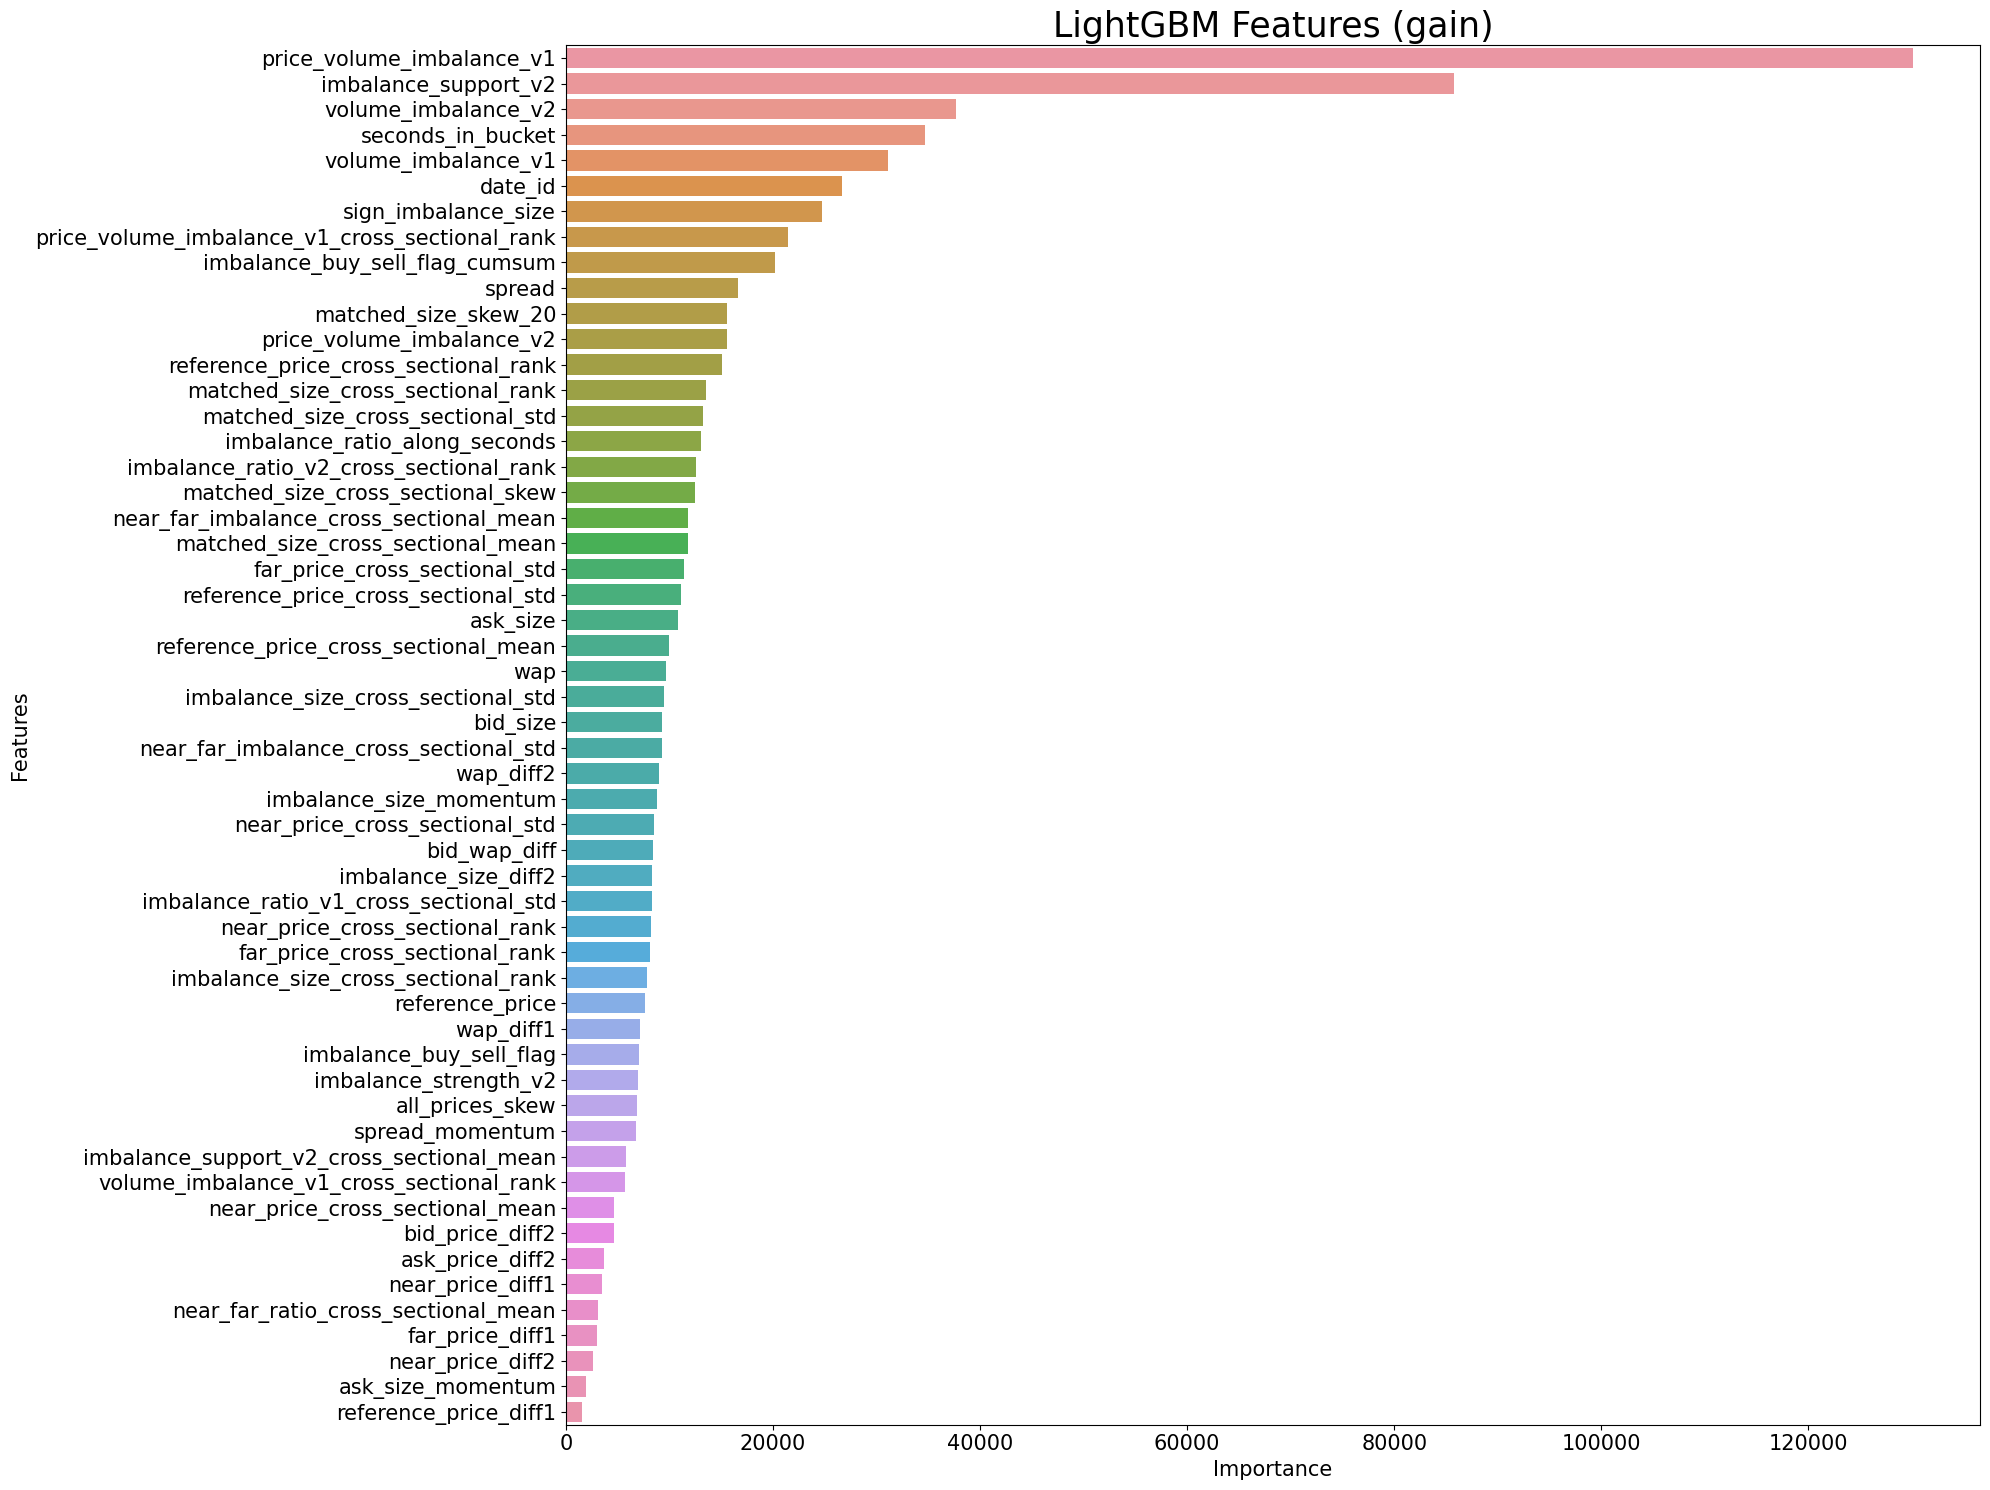

In [ ]:
metric = 'gain'  
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
imp = bst_lgb.booster_.feature_importance(importance_type=metric) 
features = bst_lgb.booster_.feature_name()
feature_importance = pd.DataFrame(imp,index=features,columns=['score']).sort_values('score',ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features','Importance']
plt.figure(figsize=(20, 15))
f = sns.barplot(x="Importance", y="Features", data=feature_importance)
# f.axes.set_title("Title",fontsize=50)
f.set_xlabel("Importance",fontsize=15)
f.set_ylabel("Features",fontsize=15)
f.tick_params(labelsize=15)
plt.title(f'LightGBM Features ({metric})',fontsize=25)
plt.tight_layout()
plt.show()

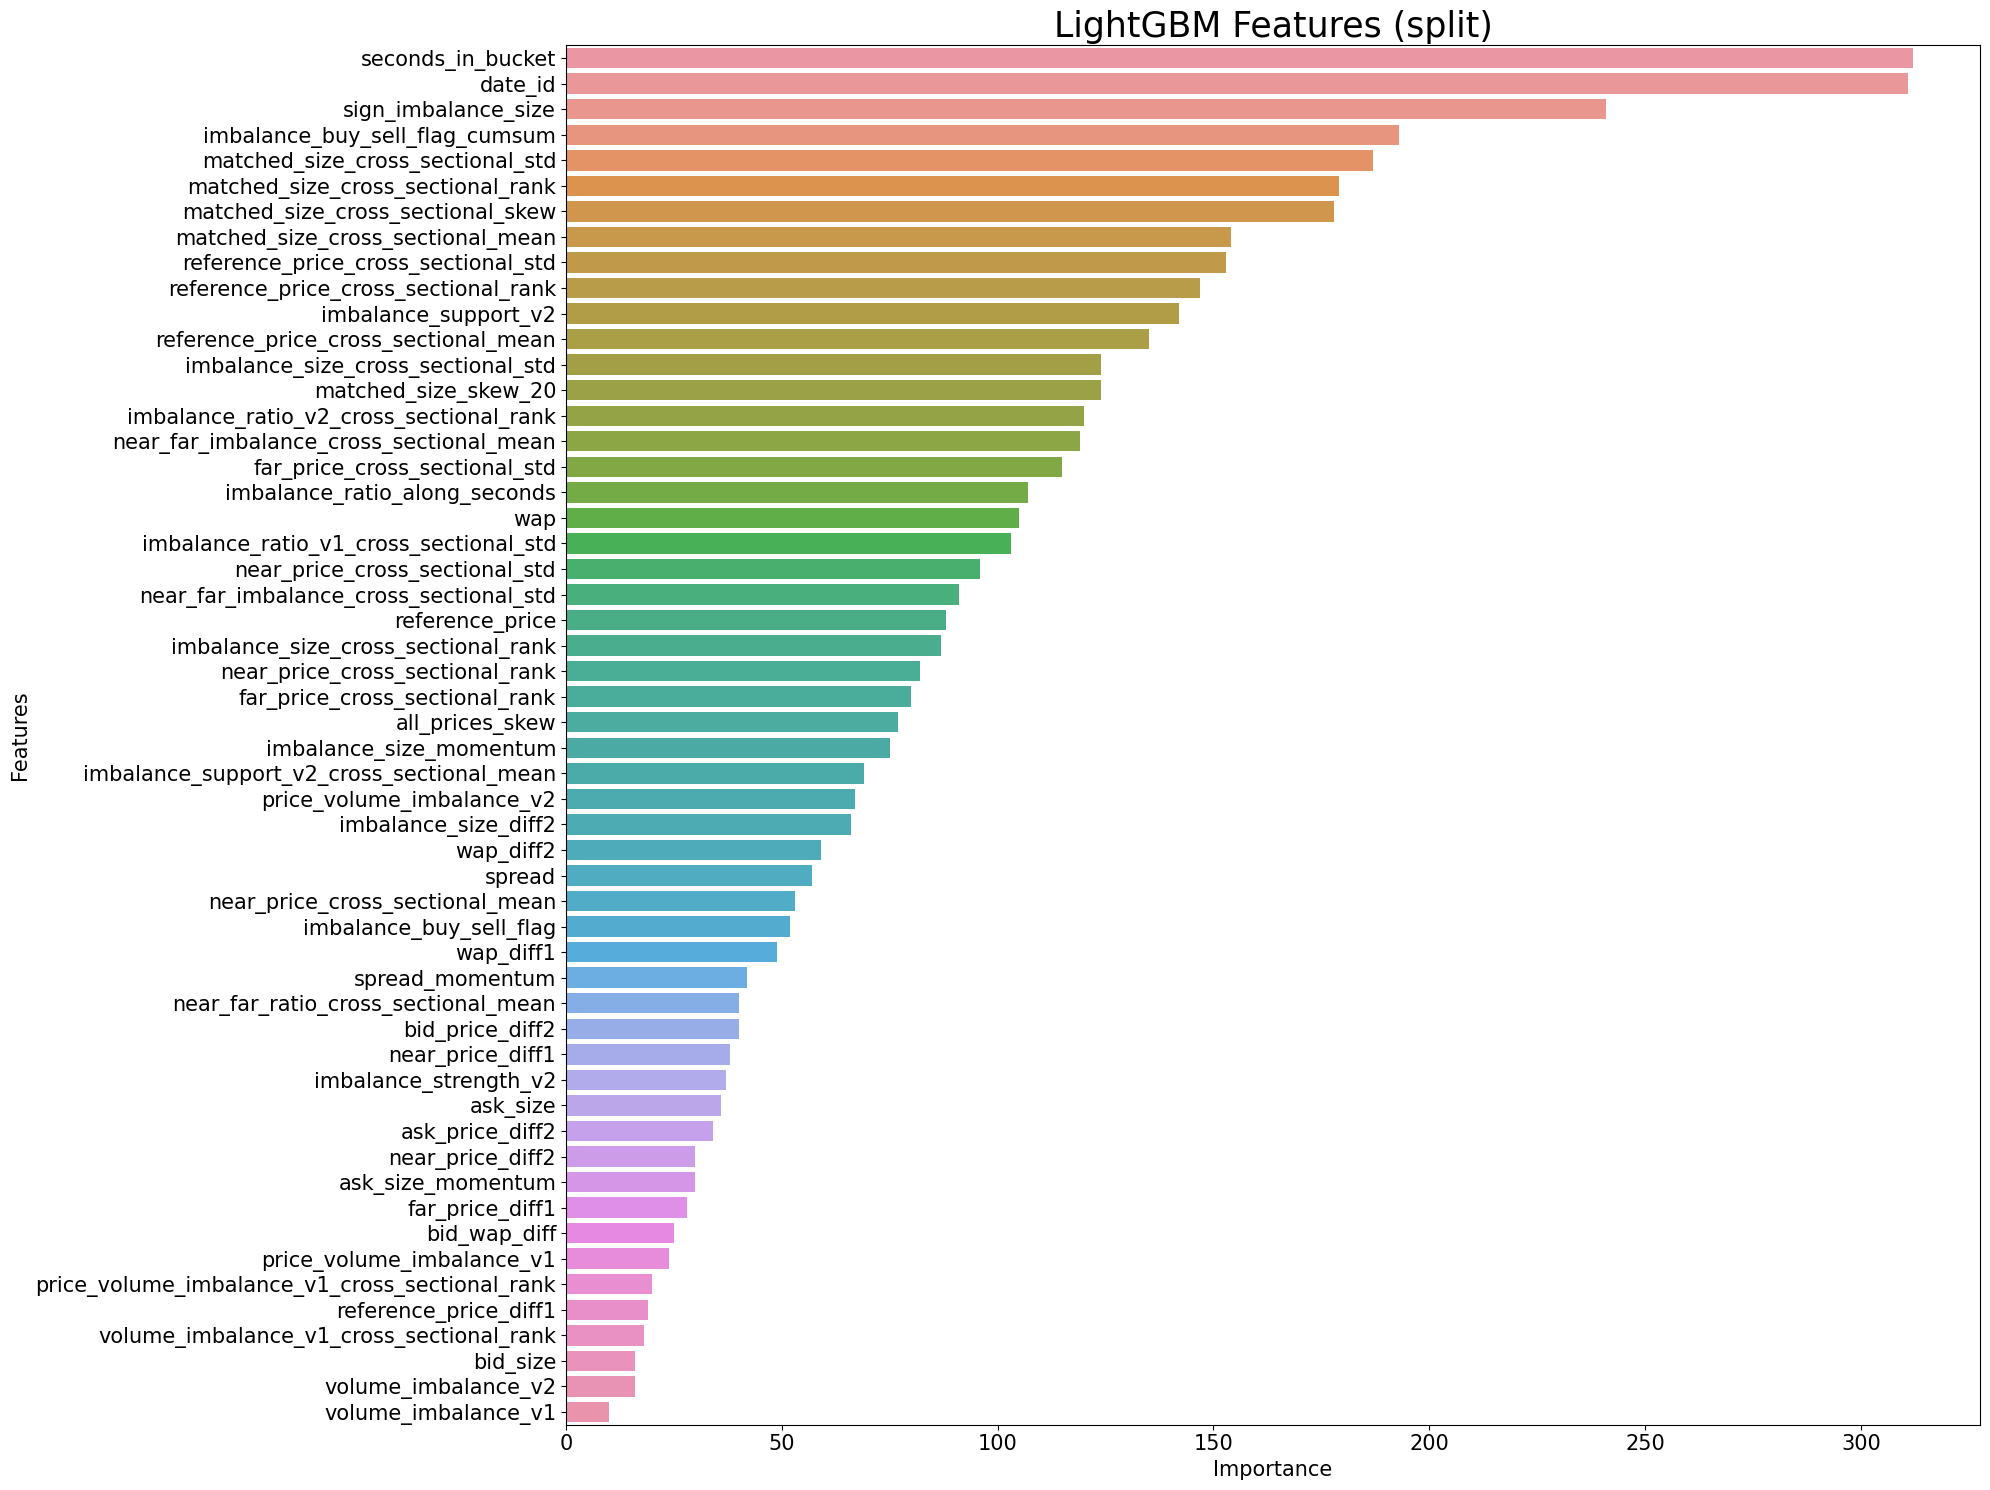

In [ ]:
metric = 'split'  
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
imp = bst_lgb.booster_.feature_importance(importance_type=metric) 
features = bst_lgb.booster_.feature_name()
feature_importance = pd.DataFrame(imp,index=features,columns=['score']).sort_values('score',ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features','Importance']
plt.figure(figsize=(20, 15))
f = sns.barplot(x="Importance", y="Features", data=feature_importance)
# f.axes.set_title("Title",fontsize=50)
f.set_xlabel("Importance",fontsize=15)
f.set_ylabel("Features",fontsize=15)
f.tick_params(labelsize=15)
plt.title(f'LightGBM Features ({metric})',fontsize=25)
plt.tight_layout()
plt.show()

## MLP

### train

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_feature):
        super(MLP, self).__init__()
        self.Input = nn.Sequential(
            nn.Linear(n_feature,64),
            nn.LeakyReLU(),
            nn.Linear(64,32),
            nn.LeakyReLU(),
            nn.Linear(32,1))
    def forward(self, x):
        out = self.Input(x)
        return out

In [ ]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

# parameters
num_epochs = 50
lr = 1e-3
lr_decay = 0.1
train_losses = []
val_losses = []

# loss function
loss_fn = nn.SmoothL1Loss()

# Model
n_features = df_train.shape[1]
model=MLP(n_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=lr_decay)

start = 1 
for epoch in tqdm.tqdm(range(start, num_epochs + start)):
    train_loss = train(model,train_dataloader,loss_fn,optimizer,device)
    val_loss = evaluate(model,val_dataloader,loss_fn,device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch[{epoch}]: train loss {train_loss}')
    print(f'Epoch[{epoch}]: validation loss {val_loss}')
#     scheduler.step()

#     checkpoint = {  "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "epoch": epoch}
#     path_checkpoint = "checkpoint_{}_epoch".format(epoch)
#     torch.save(checkpoint, path_checkpoint)

### Test

In [ ]:
from sklearn.metrics import mean_absolute_error

# evaluation mode
model.eval()
eval_loss = 0 # loss
n = 0
with torch.no_grad():
    for batch, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)
        eval_loss += mean_absolute_error(y.cpu(),pred_y.cpu().detach())
        n+=1
            
mae_MLP = eval_loss/n
print(f"MLP's MAE is {mae_MLP:.3f}")
mae_MLP

## Concolusion

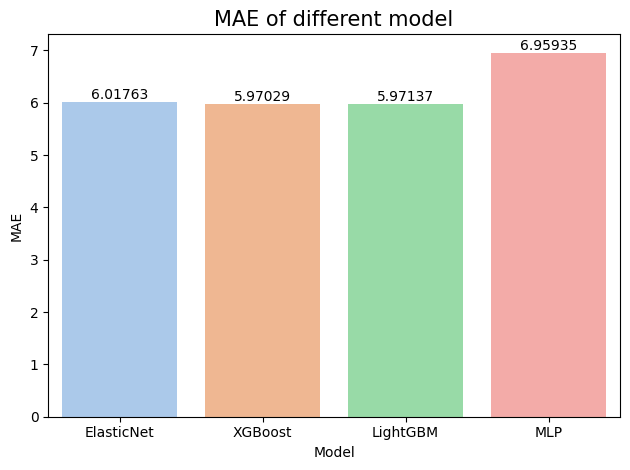

In [ ]:
res = pd.DataFrame([6.017632670611946, 5.970286832981401, 5.971366890496566, 6.959348124795339], index = ['ElasticNet','XGBoost','LightGBM','MLP'],columns=['MAE'])
res.reset_index(inplace=True)
res.columns = ['Model','MAE']
ax = sns.barplot(x='Model',y='MAE',data=res, palette = sns.color_palette("pastel"))
ax.bar_label(ax.containers[0], fontsize=10);
plt.title(f'MAE of different model',fontsize=15)
plt.tight_layout()
plt.show()